In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Colab Notebooks/MAGANG/HOME CREDIT INDONESIA/Final Task/

/content/drive/My Drive/Colab Notebooks/MAGANG/HOME CREDIT INDONESIA/Final Task


In [3]:
#Import API Account Kaggle
from google.colab import files
!ls -lha kaggle.json

-rw------- 1 root root 66 Jan 26 07:19 kaggle.json


In [4]:
#Need Permission
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

/content/drive/My Drive/Colab Notebooks/MAGANG/HOME CREDIT INDONESIA/Final Task


In [5]:
%cd Dataset/

/content/drive/My Drive/Colab Notebooks/MAGANG/HOME CREDIT INDONESIA/Final Task/Dataset


In [6]:
#Download Dataset From Kaggle
!kaggle datasets download -d dwiwahyuef/home-credit-indonesia-default-risk --force

 99% 681M/688M [00:12<00:00, 71.8MB/s]
100% 688M/688M [00:12<00:00, 56.9MB/s]


In [7]:
#Ekstrak File Dataset
!unzip home-credit-indonesia-default-risk.zip

Archive:  home-credit-indonesia-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


In [8]:
%ls

application_test.csv                home-credit-indonesia-default-risk.zip
application_train.csv               installments_payments.csv
bureau_balance.csv                  POS_CASH_balance.csv
bureau.csv                          previous_application.csv
credit_card_balance.csv             sample_submission.csv
HomeCredit_columns_description.csv


In [9]:
#Import Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

#Disable Warnings
import warnings
warnings.filterwarnings('ignore')

Read Data

In [10]:
%cd drive/My Drive/Colab Notebooks/MAGANG/HOME CREDIT INDONESIA/Final Task/Dataset/

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/MAGANG/HOME CREDIT INDONESIA/Final Task/Dataset/'
/content/drive/My Drive/Colab Notebooks/MAGANG/HOME CREDIT INDONESIA/Final Task/Dataset


In [11]:
%ls

application_test.csv                home-credit-indonesia-default-risk.zip
application_train.csv               installments_payments.csv
bureau_balance.csv                  POS_CASH_balance.csv
bureau.csv                          previous_application.csv
credit_card_balance.csv             sample_submission.csv
HomeCredit_columns_description.csv


In [12]:
df_train = pd.read_csv("application_train.csv")
df_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [13]:
df_train.shape

(307511, 122)

application_train has 307511 rows and 122 columns

In [14]:
nums = df_train.select_dtypes(include=np.number).columns
cats = df_train.select_dtypes(exclude=np.number).columns

In [15]:
df_train[nums].describe().round(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00,307511.00,307511.00,3.075110e+05,307511.00,307499.00,307233.00,307511.00,307511.00,307511.00,307511.00,307511.00,104582.00,307511.0,307511.00,307511.0,307511.00,307511.00,307511.00,307509.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,134133.00,306851.00,246546.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,151450.00,127568.00,157504.00,103023.00,92646.00,143620.00,152683.00,154491.00,98869.00,124921.00,97312.00,153161.00,93997.00,137829.00,159080.00,306490.00,306490.00,306490.00,306490.00,307510.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.0,307511.00,307511.0,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,265992.00,265992.00,265992.00,265992.00,265992.00,265992.00
mean,278180.52,0.08,0.42,1.687979e+05,599026.00,27108.57,538396.21,0.02,-16037.00,63815.05,-4986.12,-2994.20,12.06,1.0,0.82,0.2,1.00,0.28,0.06,2.15,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,0.50,0.51,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,0.98,0.76,0.04,0.07,0.15,0.22,0.23,0.06,0.11,0.11,0.01,0.03,0.12,0.09,0.98,0.76,0.04,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.10,1.42,0.14,1.41,0.10,-962.86,0.00,0.71,0.00,0.02,0.09,0.00,0.08,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.27,0.27,1.90
std,102790.18,0.27,0.72,2.371231e+05,402490.78,14493.74,369446.46,0.01,4363.99,141275.77,3522.89,1509.45,11.94,0.0,0.38,0.4,0.04,0.45,0.23,0.91,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.21,0.19,0.19,0.11,0.08,0.06,0.11,0.08,0.13,0.10,0.14,0.16,0.08,0.09,0.11,0.05,0.07,0.11,0.08,0.06,0.11,0.07,0.13,0.10,0.14,0.16,0.08,0.10,0.11,0.05,0.07,0.11,0.08,0.06,0.11,0.08,0.13,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,2.40,0.45,2.38,0.36,826.81,0.0

In [16]:
df_train[cats].describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


In [17]:
# Number of each type of column
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

# Exploratory Data Analysis (EDA)

### Univariate

In [18]:
train = df_train.copy()

Univearite : The Number of Customers Based on Their Repayment Abilities

In [19]:
decode_map = {0: "No Payment Difficulties", 1: "Payment Difficulties"}
def decode_sentiment(label):
    return decode_map[int(label)]

train['TARGET'] = train['TARGET'].apply(lambda x: decode_sentiment(x))

In [20]:
target_grp = (train[['TARGET']]
                .groupby("TARGET")
                .agg(COUNT=("TARGET","count"))
                .sort_values(by=["COUNT"],ascending=False)
                .reset_index()
                )

target_grp.style.background_gradient(cmap='Blues')

,TARGET,COUNT
0,No Payment Difficulties,282686
1,Payment Difficulties,24825


In [21]:
grp = train['TARGET'].value_counts(normalize=True)
grp.reset_index().style.background_gradient(cmap='Blues')

,index,TARGET
0,No Payment Difficulties,0.919271
1,Payment Difficulties,0.080729


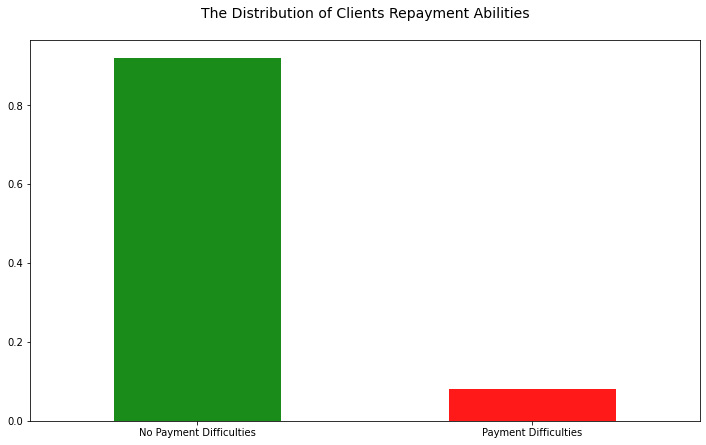

In [22]:
fig = plt.figure(figsize = (12,7))
grp.plot(kind='bar', color= ['green','red'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.show()

### **Bivariate: Categorical Features Vs Target**

**Contract Type, Gender, Car Ownership Status, and Realty Ownership Status**

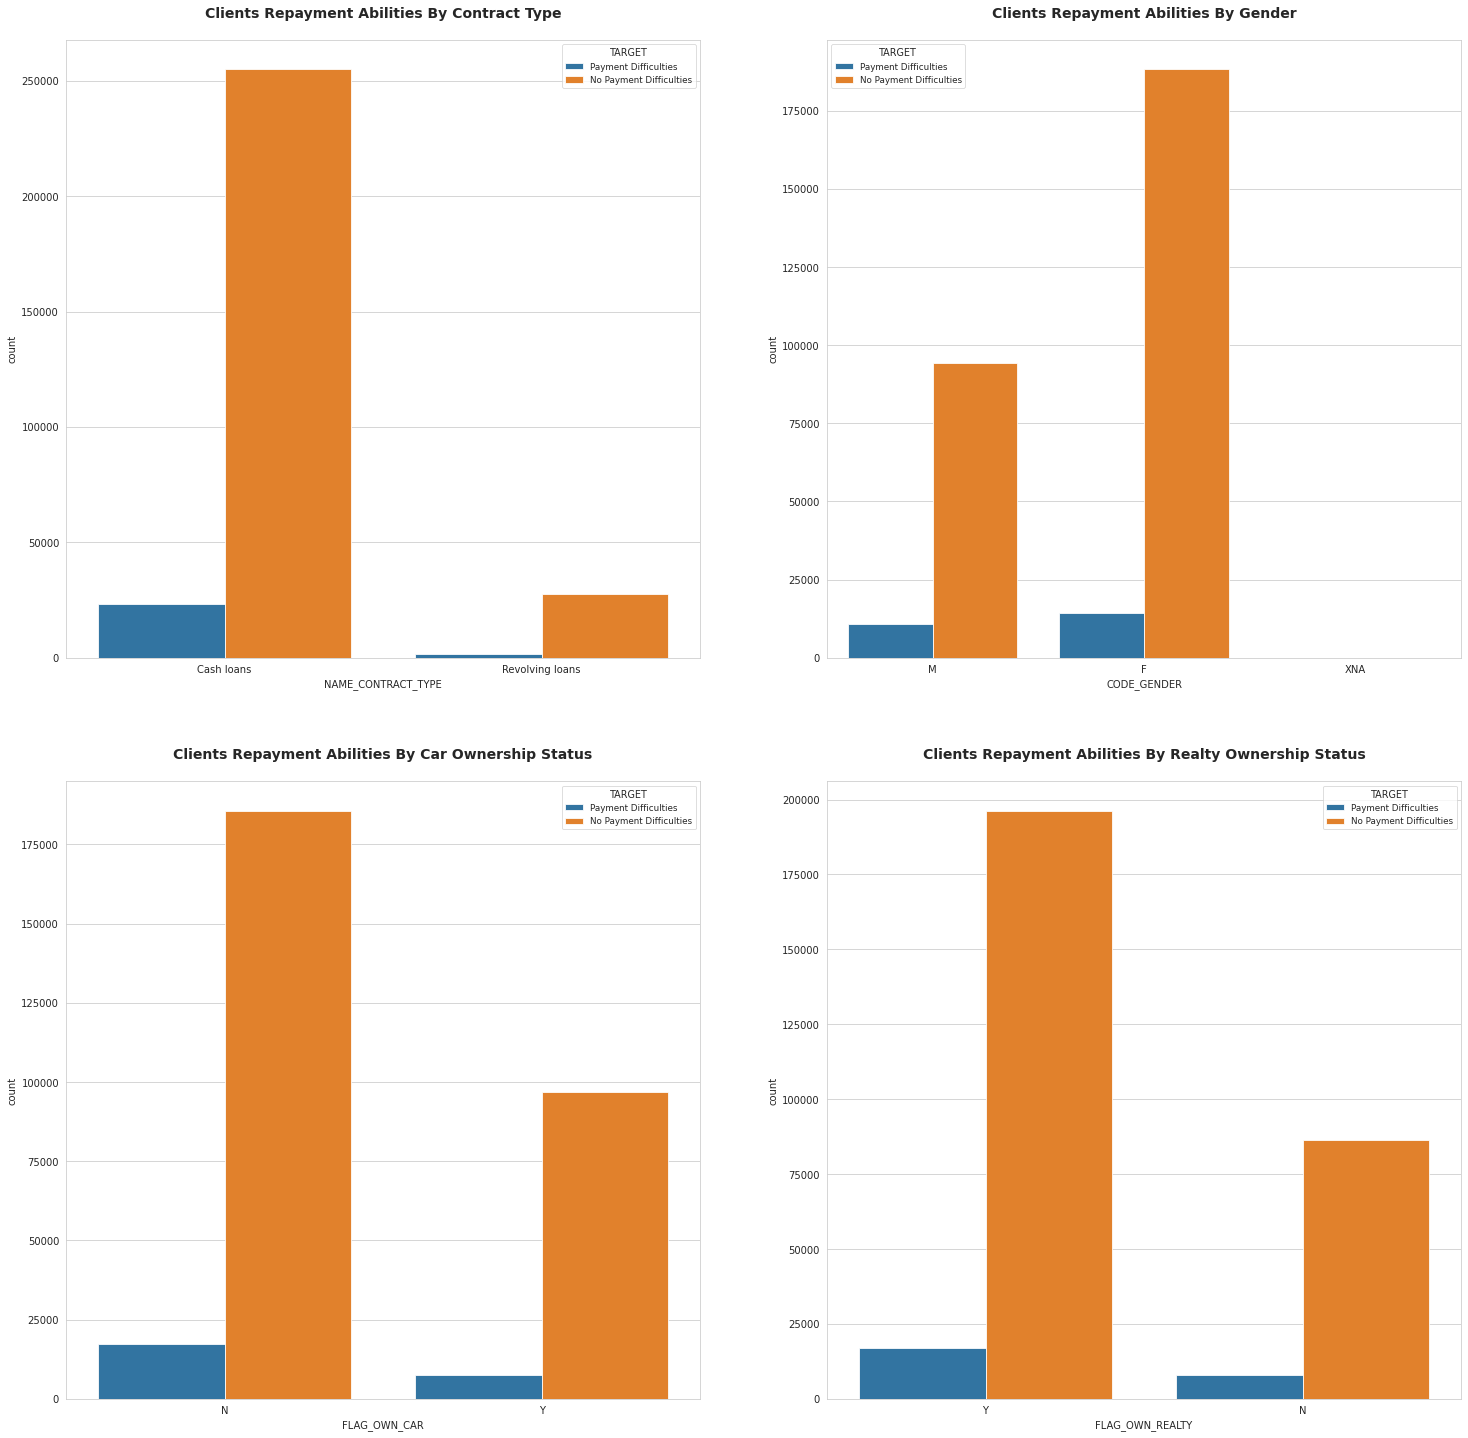

In [23]:
# visualization pt 1
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,25))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Contract Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_CONTRACT_TYPE', data = train, hue = 'TARGET', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Gender\n', fontweight='bold', fontsize=14)
sns.countplot(x='CODE_GENDER', data = train, hue = 'TARGET', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Car Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_CAR', data = train, hue = 'TARGET', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Realty Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_REALTY', data = train, hue = 'TARGET', ax=ax[1][1])

Contract Type Vs Target

In [24]:
ct = train.groupby(by=['NAME_CONTRACT_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Contract Type')
ct.sort_values(by='SK_ID_CURR', ascending=False)
ct.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Contract Type


,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR
0,Cash loans,No Payment Difficulties,255011
1,Cash loans,Payment Difficulties,23221
2,Revolving loans,No Payment Difficulties,27675
3,Revolving loans,Payment Difficulties,1604


Cash loans with 278,000 loans accounted for most of the total loans in this data set. Revolving loans have a much lower amount of around 29K compared to cash loans.

Gender vs Target

In [25]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace(['F','M'],['Female','Male'])

In [26]:
gt = train.groupby(by=['CODE_GENDER','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Gender')
gt.sort_values(by='SK_ID_CURR', ascending=False)
gt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Gender


,CODE_GENDER,TARGET,SK_ID_CURR
0,Female,No Payment Difficulties,188278
1,Female,Payment Difficulties,14170
2,Male,No Payment Difficulties,94404
3,Male,Payment Difficulties,10655
4,XNA,No Payment Difficulties,4


In [27]:
df_train[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101419
0,F,0.069993
2,XNA,0.000000


It can be seen that women have applied for most of the loans. In total, there were around 202,448 loan applications submitted by women, and about 105,059 applications submitted by men.

However, a larger percentage (about 10% of the total) of male clients have problems repaying loans compared to female clients (about 7%).

Car Ownership vs Target

In [28]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace(['Y','N'],['Yes','No'])

In [29]:
ot = train.groupby(by=['FLAG_OWN_CAR','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Car Ownership Status')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Car Ownership Status


,FLAG_OWN_CAR,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,185675
1,No,Payment Difficulties,17249
2,Yes,No Payment Difficulties,97011
3,Yes,Payment Difficulties,7576


In [30]:
df_train[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.085002
1,Y,0.072437


Most of the clients do not own a car.

Customers who own a car (approximately 8%) have difficulty repaying loans compared to customers who do not own a car (about 7%). However, the difference is not very significant.

Realty Ownership Status Vs Target

In [31]:
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace(['Y','N'],['Yes','No'])

In [32]:
rt = train.groupby(by=['FLAG_OWN_REALTY','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Realty Ownership Status')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Realty Ownership Status


,FLAG_OWN_REALTY,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,86357
1,No,Payment Difficulties,7842
2,Yes,No Payment Difficulties,196329
3,Yes,Payment Difficulties,16983


In [33]:
df_train[['FLAG_OWN_REALTY','TARGET']].groupby(['FLAG_OWN_REALTY'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_REALTY,TARGET
0,N,0.083249
1,Y,0.079616


Most clients own flats/houses.

Customers who own houses/flats (about 8%) have difficulty repaying loans compared to customers who do not own houses/flats (about 7%). However, the difference is not very significant.

**Suite Type, Income Type, Education Type, and Family Status**

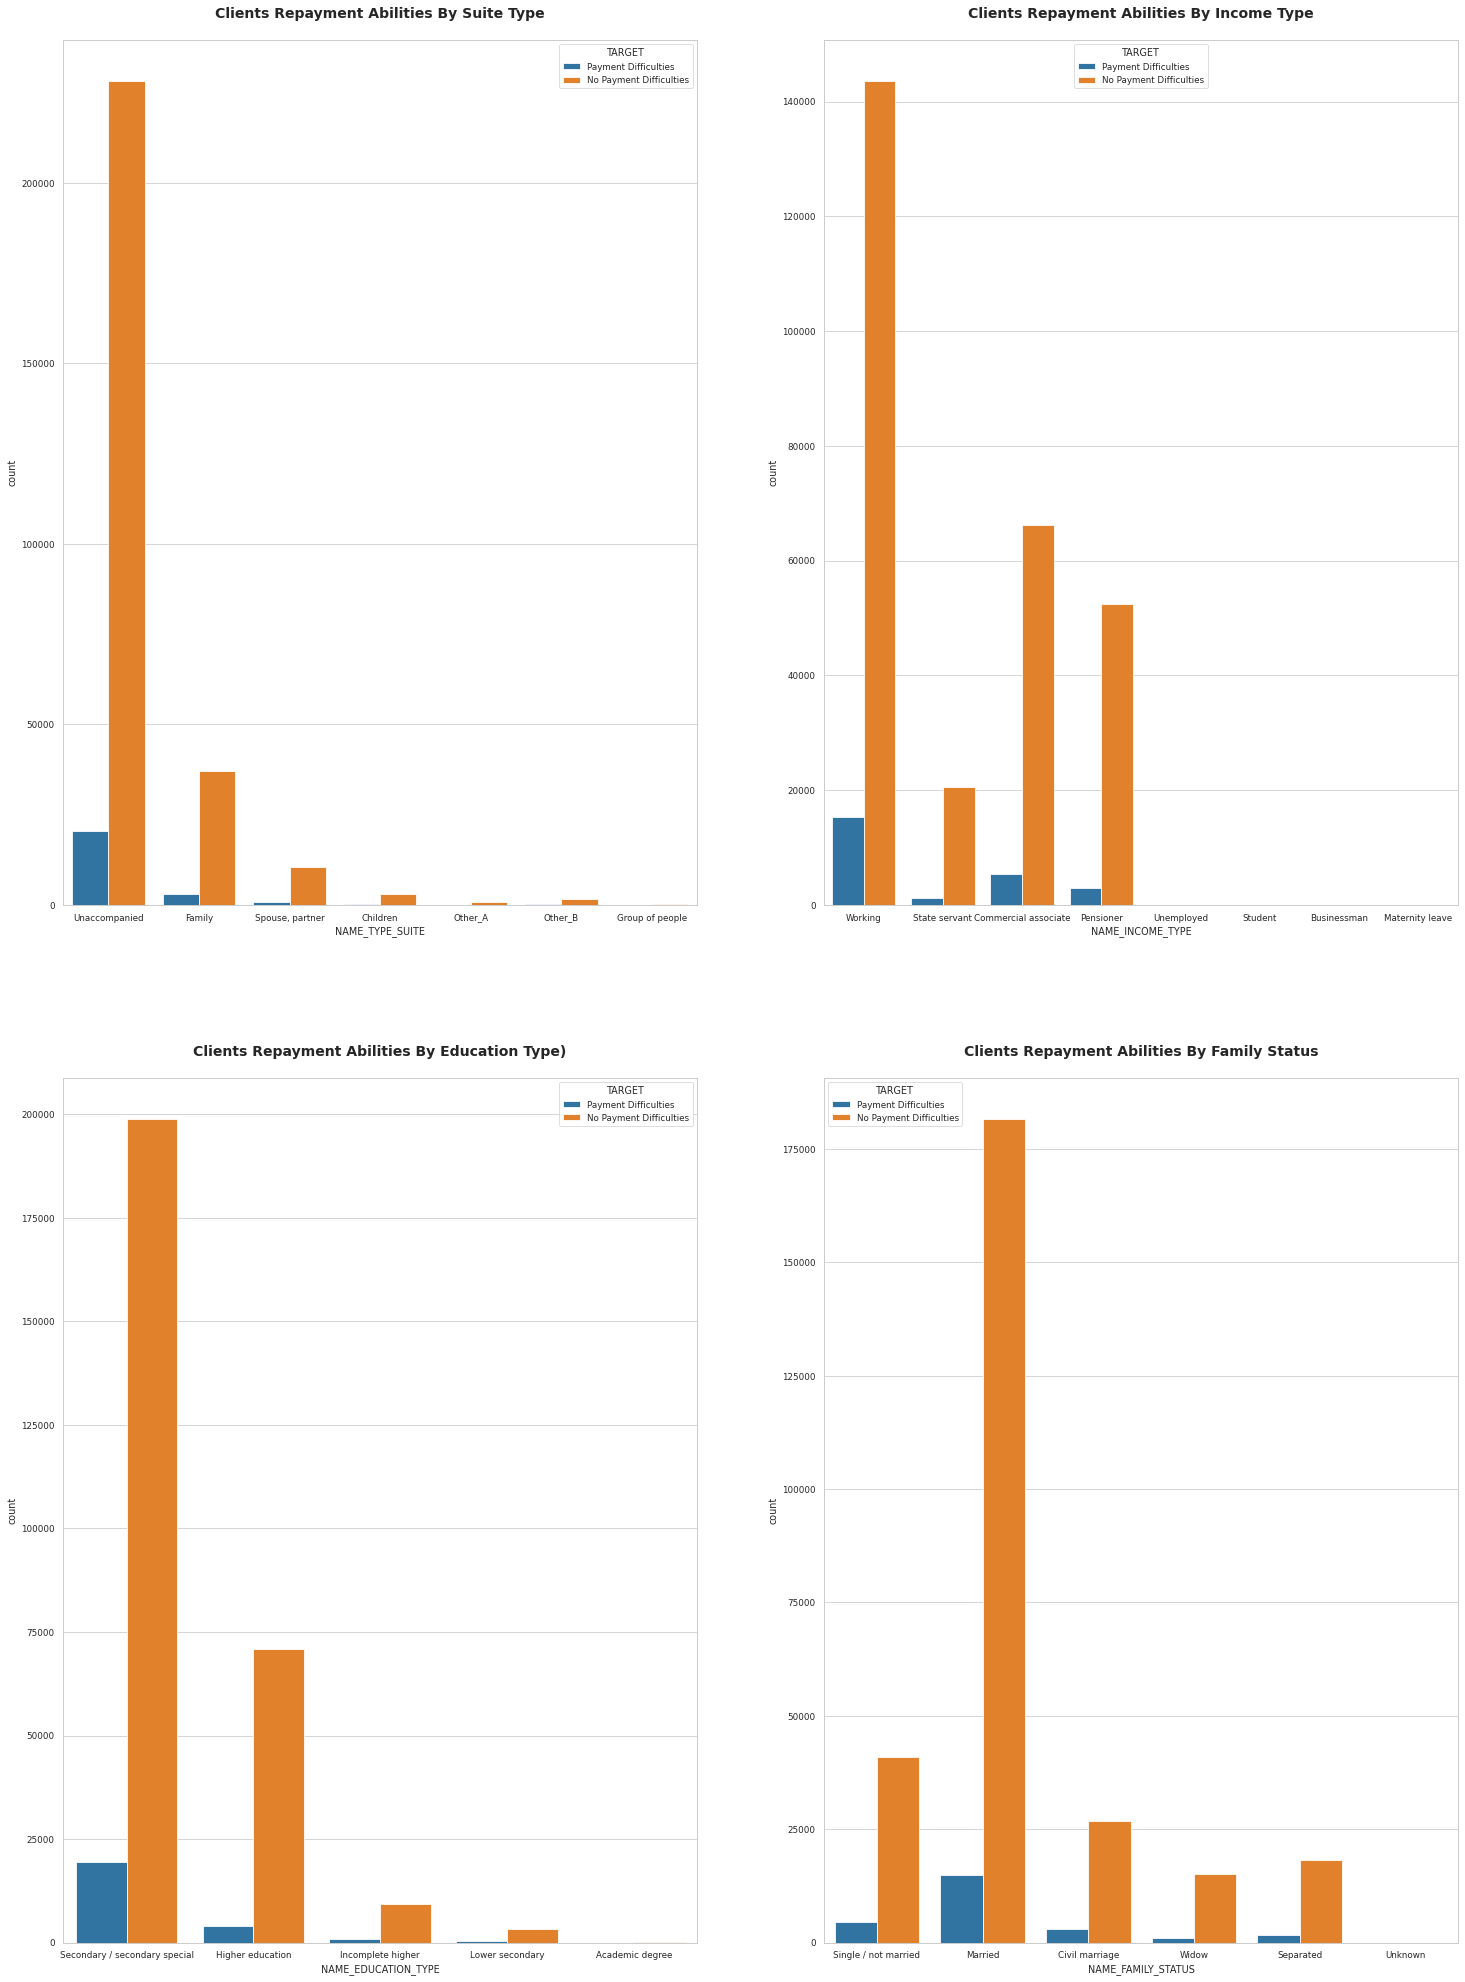

In [34]:
# visualization pt. 2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,35))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Suite Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_TYPE_SUITE', data = train, hue = 'TARGET', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Income Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_INCOME_TYPE', data = train, hue = 'TARGET', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Education Type)\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_EDUCATION_TYPE', data = train, hue = 'TARGET', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Family Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_FAMILY_STATUS', data = train, hue = 'TARGET', ax=ax[1][1])

Suite Type Vs Target

In [35]:
st = train.groupby(by=['NAME_TYPE_SUITE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
st.sort_values(by='SK_ID_CURR', ascending=False)
st.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,NAME_TYPE_SUITE,TARGET,SK_ID_CURR
0,Children,No Payment Difficulties,3026
1,Children,Payment Difficulties,241
2,Family,No Payment Difficulties,37140
3,Family,Payment Difficulties,3009
4,Group of people,No Payment Difficulties,248
5,Group of people,Payment Difficulties,23
6,Other_A,No Payment Difficulties,790
7,Other_A,Payment Difficulties,76
8,Other_B,No Payment Difficulties,1596
9,Other_B,Payment Difficulties,174


In [36]:
df_train[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
4,Other_B,0.098305
3,Other_A,0.087760
2,Group of people,0.084871
6,Unaccompanied,0.081830
5,"Spouse, partner",0.078716
1,Family,0.074946
0,Children,0.073768


clients who were in the other_b group when applying for a loan had a higher percentage of difficulty in repaying the loan (about 10%).

Income Type Vs Target

In [37]:
rt = train.groupby(by=['NAME_INCOME_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Income Type')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Income Type


,NAME_INCOME_TYPE,TARGET,SK_ID_CURR
0,Businessman,No Payment Difficulties,10
1,Commercial associate,No Payment Difficulties,66257
2,Commercial associate,Payment Difficulties,5360
3,Maternity leave,No Payment Difficulties,3
4,Maternity leave,Payment Difficulties,2
5,Pensioner,No Payment Difficulties,52380
6,Pensioner,Payment Difficulties,2982
7,State servant,No Payment Difficulties,20454
8,State servant,Payment Difficulties,1249
9,Student,No Payment Difficulties,18


In [38]:
df_train[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.400000
6,Unemployed,0.363636
7,Working,0.095885
1,Commercial associate,0.074843
4,State servant,0.057550
3,Pensioner,0.053864
0,Businessman,0.000000
5,Student,0.000000


It can be seen that working clients have applied for most of the loans, which is around 158,774 loan applications.

Customers with business and student income types do not have difficulty paying off their loans.

While clients who are on maternity leave and unemployed have the highest percentage (about 40% and 36%) of TARGET = 1, ie. having problems repaying the loan.

Education Type Vs Target

In [39]:
et = train.groupby(by=['NAME_EDUCATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Education Type')
et.sort_values(by='SK_ID_CURR', ascending=False)
et.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Education Type


,NAME_EDUCATION_TYPE,TARGET,SK_ID_CURR
0,Academic degree,No Payment Difficulties,161
1,Academic degree,Payment Difficulties,3
2,Higher education,No Payment Difficulties,70854
3,Higher education,Payment Difficulties,4009
4,Incomplete higher,No Payment Difficulties,9405
5,Incomplete higher,Payment Difficulties,872
6,Lower secondary,No Payment Difficulties,3399
7,Lower secondary,Payment Difficulties,417
8,Secondary / secondary special,No Payment Difficulties,198867
9,Secondary / secondary special,Payment Difficulties,19524


In [40]:
df_train[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.109277
4,Secondary / secondary special,0.089399
2,Incomplete higher,0.084850
1,Higher education,0.053551
0,Academic degree,0.018293


A large number of applications (218K) were submitted by clients having secondary education followed by people with higher education with 75K applications.

Meanwhile, clients with high school education have the highest percentage (about 10%) of TARGET = 1, ie. having problems repaying the loan.

Family Status Vs Target

In [41]:
ft = train.groupby(by=['NAME_FAMILY_STATUS','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Family Status')
ft.sort_values(by='SK_ID_CURR', ascending=False)
ft.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Family Status


,NAME_FAMILY_STATUS,TARGET,SK_ID_CURR
0,Civil marriage,No Payment Difficulties,26814
1,Civil marriage,Payment Difficulties,2961
2,Married,No Payment Difficulties,181582
3,Married,Payment Difficulties,14850
4,Separated,No Payment Difficulties,18150
5,Separated,Payment Difficulties,1620
6,Single / not married,No Payment Difficulties,40987
7,Single / not married,Payment Difficulties,4457
8,Unknown,No Payment Difficulties,2
9,Widow,No Payment Difficulties,15151


In [42]:
df_train[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_FAMILY_STATUS,TARGET
0,Civil marriage,0.099446
3,Single / not married,0.098077
2,Separated,0.081942
1,Married,0.075599
5,Widow,0.058242
4,Unknown,0.000000


It can be seen that the majority of married customers apply for loans, which is around 196,432 loan applications.

Clients with civilly married and single family status have the highest percentage (about 9%) of clients having problems in repaying loans.

 **Housing Type, Occupation Type, Process Day, and Organization Type**

Housing Type Vs Target

In [43]:
ht = train.groupby(by=['NAME_HOUSING_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Housing Type')
ht.sort_values(by='SK_ID_CURR', ascending=False)
ht.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Housing Type


,NAME_HOUSING_TYPE,TARGET,SK_ID_CURR
0,Co-op apartment,No Payment Difficulties,1033
1,Co-op apartment,Payment Difficulties,89
2,House / apartment,No Payment Difficulties,251596
3,House / apartment,Payment Difficulties,21272
4,Municipal apartment,No Payment Difficulties,10228
5,Municipal apartment,Payment Difficulties,955
6,Office apartment,No Payment Difficulties,2445
7,Office apartment,Payment Difficulties,172
8,Rented apartment,No Payment Difficulties,4280
9,Rented apartment,Payment Difficulties,601


In [44]:
df_train[['NAME_HOUSING_TYPE','TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.123131
5,With parents,0.116981
2,Municipal apartment,0.085397
0,Co-op apartment,0.079323
1,House / apartment,0.077957
3,Office apartment,0.065724


It can be seen that customers with apartment rental houses have the highest percentage (around 12%) in difficulty in repaying loans.

Text(0.5, 0, '\nHousing Type')

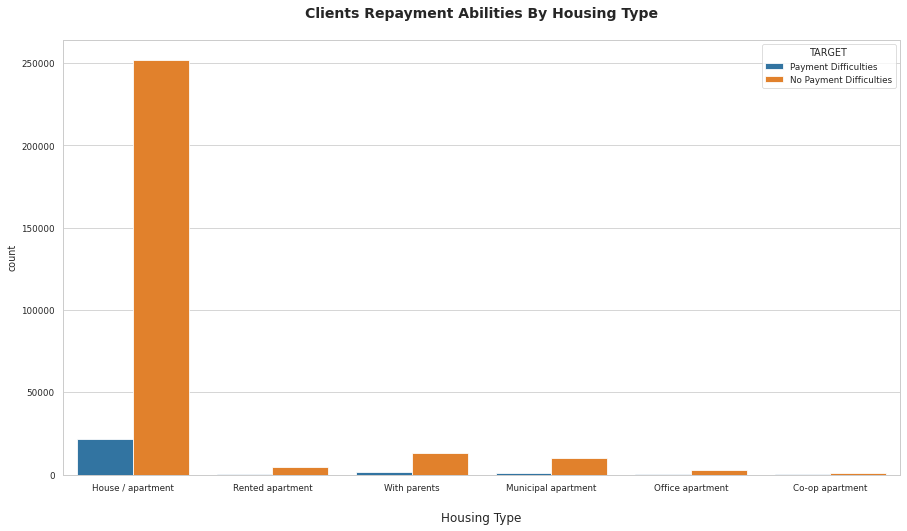

In [45]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x='NAME_HOUSING_TYPE', data = train, hue = 'TARGET')
plt.title('Clients Repayment Abilities By Housing Type\n', fontweight='bold', fontsize=14)
plt.xlabel('\nHousing Type', fontsize=12)

Clients who live in houses/apartments have the highest number of loan applications of 272K.

**Occupation Type Vs Target**

In [46]:
ot = train.groupby(by=['OCCUPATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Occupation Type')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Occupation Type


,OCCUPATION_TYPE,TARGET,SK_ID_CURR
0,Accountants,No Payment Difficulties,9339
1,Accountants,Payment Difficulties,474
2,Cleaning staff,No Payment Difficulties,4206
3,Cleaning staff,Payment Difficulties,447
4,Cooking staff,No Payment Difficulties,5325
5,Cooking staff,Payment Difficulties,621
6,Core staff,No Payment Difficulties,25832
7,Core staff,Payment Difficulties,1738
8,Drivers,No Payment Difficulties,16496
9,Drivers,Payment Difficulties,2107


In [47]:
df_train[['OCCUPATION_TYPE','TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.171524
4,Drivers,0.113261
17,Waiters/barmen staff,0.112760
16,Security staff,0.107424
8,Laborers,0.105788
2,Cooking staff,0.104440
14,Sales staff,0.096318
1,Cleaning staff,0.096067
13,Realty agents,0.078562
15,Secretaries,0.070498


Most applications (55K) are submitted by clients who work as Laborers.

It can be seen that clients with Low-skilled Labor have the highest percentage (around 17%) of TARGET = 1, ie. having problems repaying the loan.

**Process Day Vs Target**

In [48]:
pt = train.groupby(by=['WEEKDAY_APPR_PROCESS_START','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Process Day')
pt.sort_values(by='SK_ID_CURR', ascending=False)
pt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Process Day


,WEEKDAY_APPR_PROCESS_START,TARGET,SK_ID_CURR
0,FRIDAY,No Payment Difficulties,46237
1,FRIDAY,Payment Difficulties,4101
2,MONDAY,No Payment Difficulties,46780
3,MONDAY,Payment Difficulties,3934
4,SATURDAY,No Payment Difficulties,31182
5,SATURDAY,Payment Difficulties,2670
6,SUNDAY,No Payment Difficulties,14898
7,SUNDAY,Payment Difficulties,1283
8,THURSDAY,No Payment Difficulties,46493
9,THURSDAY,Payment Difficulties,4098


In [49]:
df_train[['WEEKDAY_APPR_PROCESS_START','TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WEEKDAY_APPR_PROCESS_START,TARGET
5,TUESDAY,0.083505
6,WEDNESDAY,0.081604
0,FRIDAY,0.081469
4,THURSDAY,0.081003
3,SUNDAY,0.079291
2,SATURDAY,0.078873
1,MONDAY,0.077572


Text(0.5, 0, '\nProcess Day')

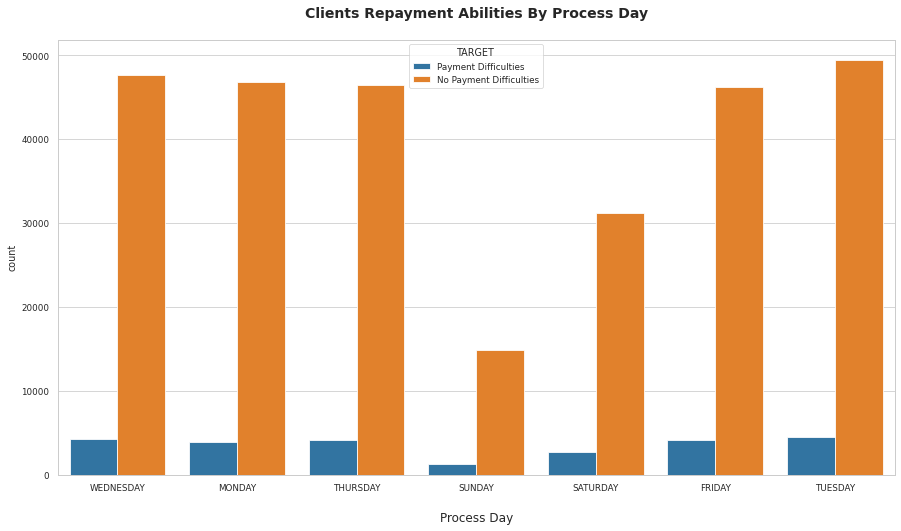

In [50]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x='WEEKDAY_APPR_PROCESS_START', data = train, hue = 'TARGET')
plt.title('Clients Repayment Abilities By Process Day\n', fontweight='bold', fontsize=14)
plt.xlabel('\nProcess Day', fontsize=12)

It can be seen that every day the application processing has almost the same percentage (about 7% - 8%) of TARGET = 1, ie. having problems repaying the loan.

**Organization Type Vs Target**

In [51]:
tt = train.groupby(by=['ORGANIZATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
tt.sort_values(by='SK_ID_CURR', ascending=False)
tt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,Advertising,No Payment Difficulties,394
1,Advertising,Payment Difficulties,35
2,Agriculture,No Payment Difficulties,2197
3,Agriculture,Payment Difficulties,257
4,Bank,No Payment Difficulties,2377
5,Bank,Payment Difficulties,130
6,Business Entity Type 1,No Payment Difficulties,5497
7,Business Entity Type 1,Payment Difficulties,487
8,Business Entity Type 2,No Payment Difficulties,9653
9,Business Entity Type 2,Payment Difficulties,900


In [52]:
df_train[['ORGANIZATION_TYPE','TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,ORGANIZATION_TYPE,TARGET
54,Transport: type 3,0.157540
18,Industry: type 13,0.134328
25,Industry: type 8,0.125000
38,Restaurant,0.117062
7,Construction,0.116798
6,Cleaning,0.111538
14,Industry: type 1,0.110683
20,Industry: type 3,0.106162
36,Realtor,0.106061
1,Agriculture,0.104727


It is seen that clients from the transportation industry: type 3 have the highest percentage (about 15%) of TARGET = 1, ie. having problems repaying the loan.

### **Bivariate: Numerical Features Vs Target**

**Amount Credit of the Loan Vs Target**

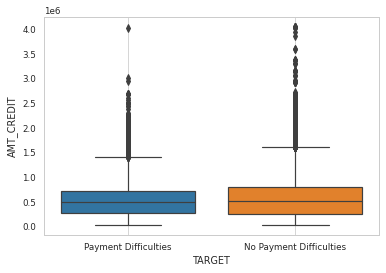

In [53]:
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=train)
plt.grid()
plt.show()

It can be seen that the median value of the number of credit customers who do not experience payment difficulties is slightly higher than the median value of customers who experience payment difficulties. This means that clients with higher credit scores have a slightly higher chance of being able to repay the loan than clients with lower credit amounts.

**Amount Income Vs Target**

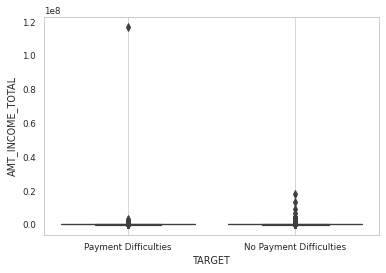

In [54]:
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=train)
plt.grid()
plt.show()

It can be seen that both clients who experience payment difficulties and clients who do not experience payment difficulties, mostly have the same value. However, as the client's income increases, the likelihood that the client will have no trouble repaying the loan also increases.

**Age Vs target**

In [55]:
no_age = df_train[df_train['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df_train[df_train['TARGET']==1]['DAYS_BIRTH'].values/-365

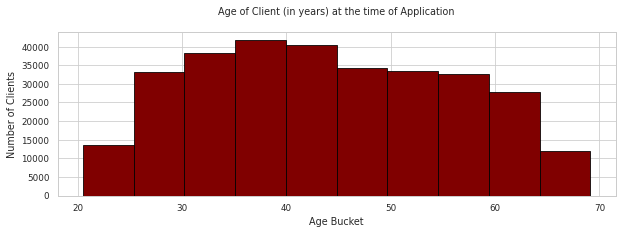

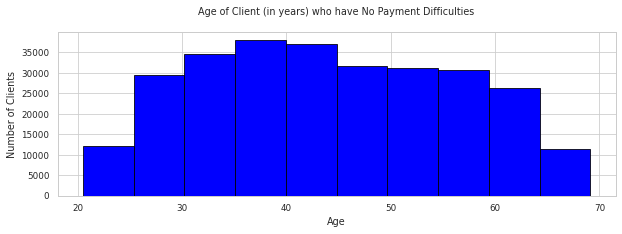

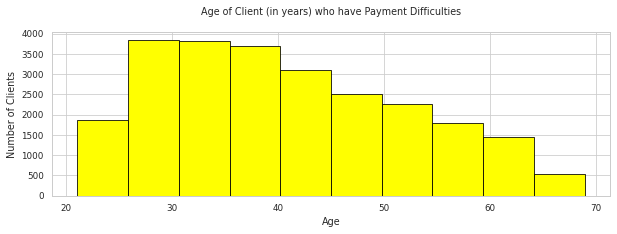

In [56]:
plt.figure(figsize=(10,3))
plt.hist(df_train['DAYS_BIRTH'].values/-365, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client (in years) at the time of Application\n')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(no_age, bins=10, edgecolor='black', color='blue')
plt.title('Age of Client (in years) who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(yes_age, bins=10, edgecolor='black', color='yellow')
plt.title('Age of Client (in years) who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

The number of customers who apply for loans is mostly in the 30-40 year range, followed by customers in the 40-45 year range. Meanwhile, the number of applicants for clients aged <25 years or age>65 years is very small.

Clients who experience payment difficulties are clients with an age range of 35-45 years. While clients aged 60-70 don't have too many difficulties

### Multivariant Visualization
**Group by Realty Ownership Status**

1. Income Type, Amount of Goods Price, Target, and House/Flat Ownership

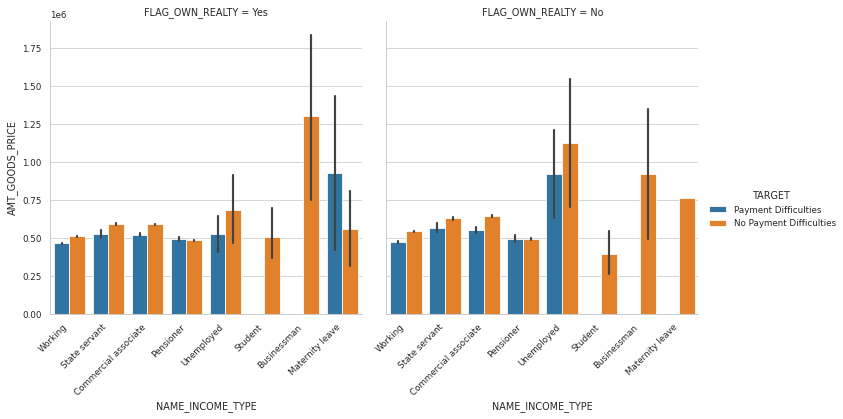

In [57]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_GOODS_PRICE', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients with maternity leave income type at FLAG_OWN_REALTY = Yes (i.e. owns a house/flat) have problems repaying loans compared to when FLAG_OWN_REALTY = No (i.e. does not own a house/flat).

2. Car Ownership Status, The Number of Children, Target, and House/Flat Ownership Status

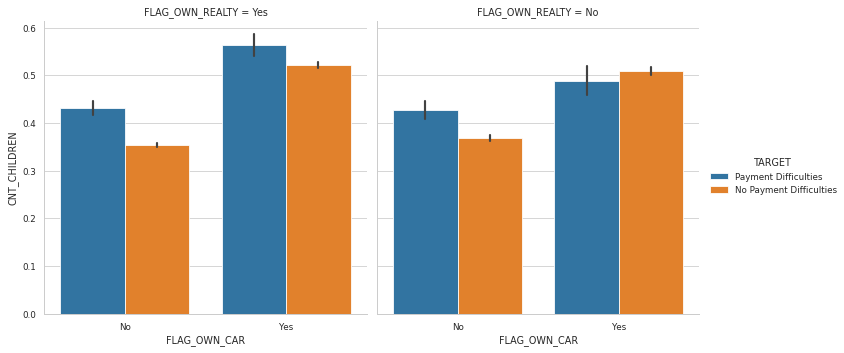

In [58]:
sns.catplot(x = 'FLAG_OWN_CAR',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar',
            data = train)
plt.show()

Clients who own cars and houses/flats have problems repaying loans for a high number of children compared to clients who do not own houses/flats.

3. Family Status, Amount of Income, Target, and House/Flat Ownership Status

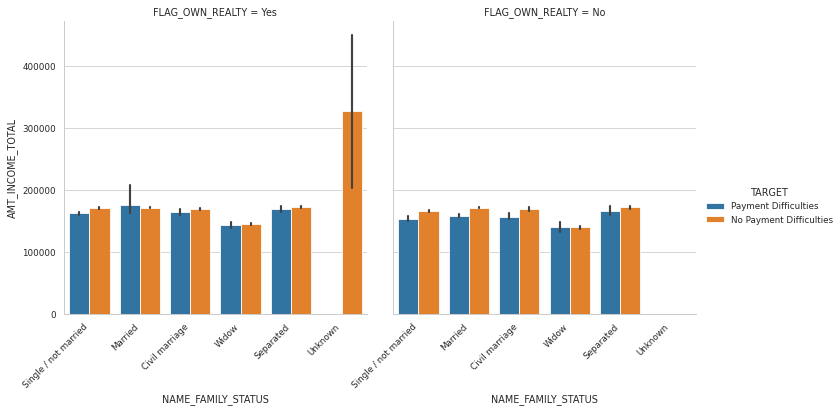

In [59]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_INCOME_TOTAL', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients who are married and own a house/flat (FLAG_OWN_REALTY = Yes) have problems repaying loans for medium income compared to clients who do not own a house/flat (FLAG_OWN_REALTY = No).

**Grouped by Car Ownership Status**

Contract Type, The Number of Children, Target, and Car Ownership Status

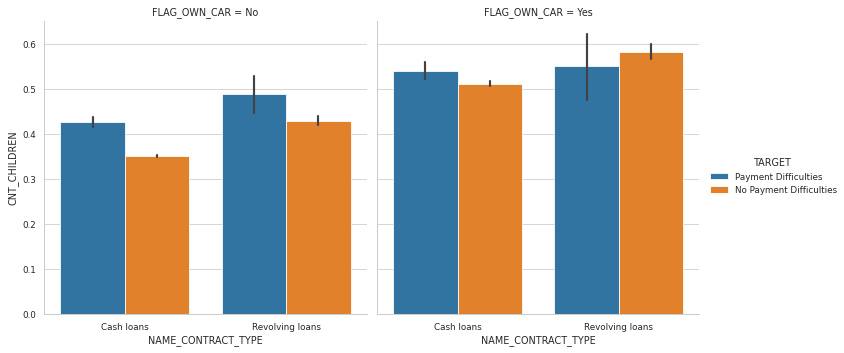

In [60]:
sns.catplot(x = 'NAME_CONTRACT_TYPE',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_CAR', 
            kind = 'bar',
            data = train)
plt.show()

For revolving loans in FLAG_OWN_CAR = No (i.e. not owning a car) have problems repaying the loan compared to when FLAG_OWN_CAR = Yes (i.e. owning a car).

**Grouped by Contract Type**

Income Type, Amount of Credit, Target, and Contract Type

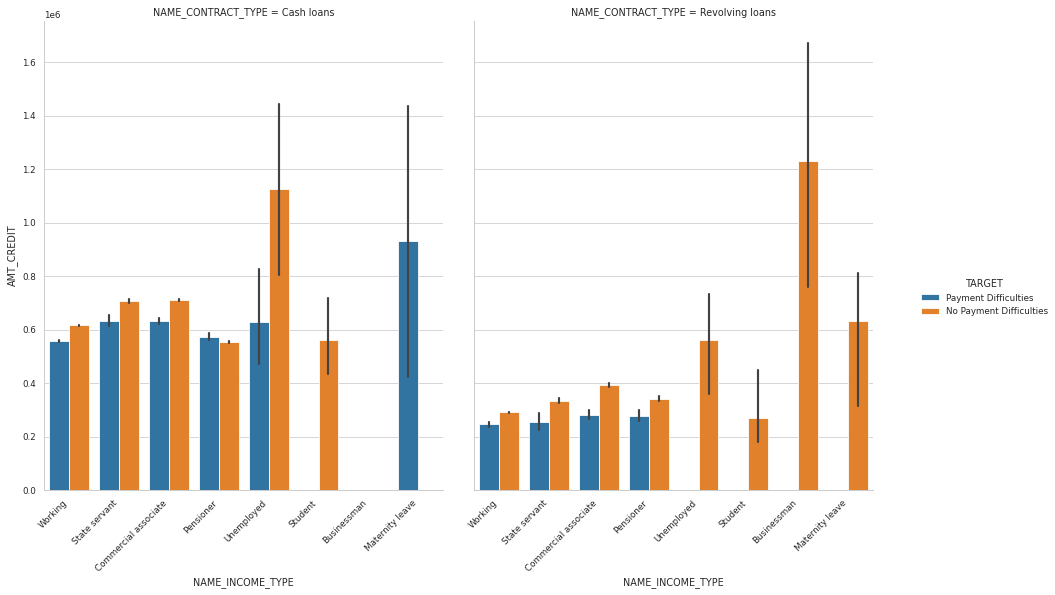

In [61]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'NAME_CONTRACT_TYPE', 
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(15, 8)
plt.show()

For the income type of maternity leave with cash loans, all clients have problems repaying loans for medium credit loan amounts. While all clients on maternity leave and revolving loans have no difficulty repaying the loan.

For unemployed clients with cash loans, more than 50% of clients have problems repaying loans with medium credit amounts from loans. While all unemployed clients with revolving loans have no difficulty repaying the loan.

All student clients have no difficulty repaying loans either with cash loans or revolving loans for low to medium loan amounts.

**Grouped by Rating of Region where Client Lives**

1. Family Status, Amount Credit of Loan, Target, and Rating of Region where Client Lives

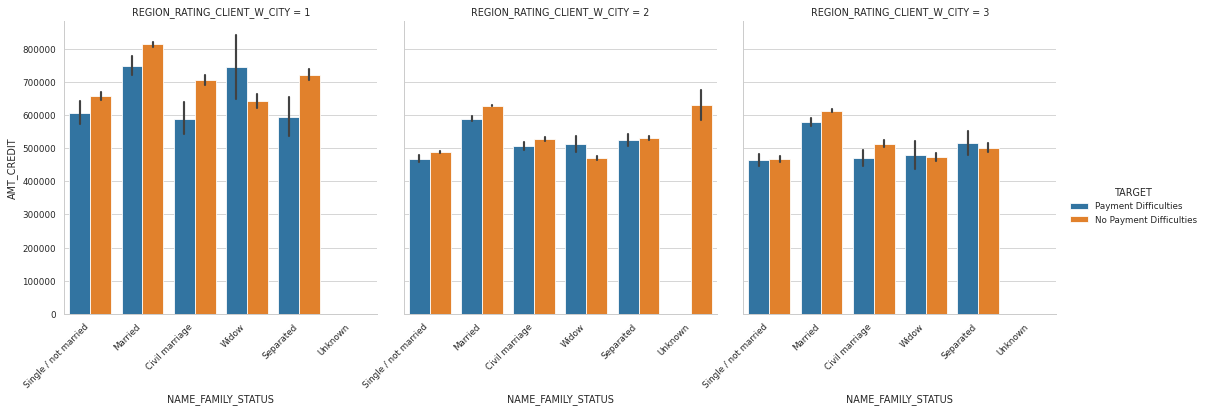

In [62]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT_W_CITY', 
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients who are widowed, whether domiciled in areas with a rating of 1, 2, or 3, have difficulty paying off loans for moderate to high loan amounts.

Clients who have separate family status, and live in areas rated 3, have problems repaying loans for a moderate amount of loan credit compared to clients who live in areas rated 1 or 2.

2. Housing Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives

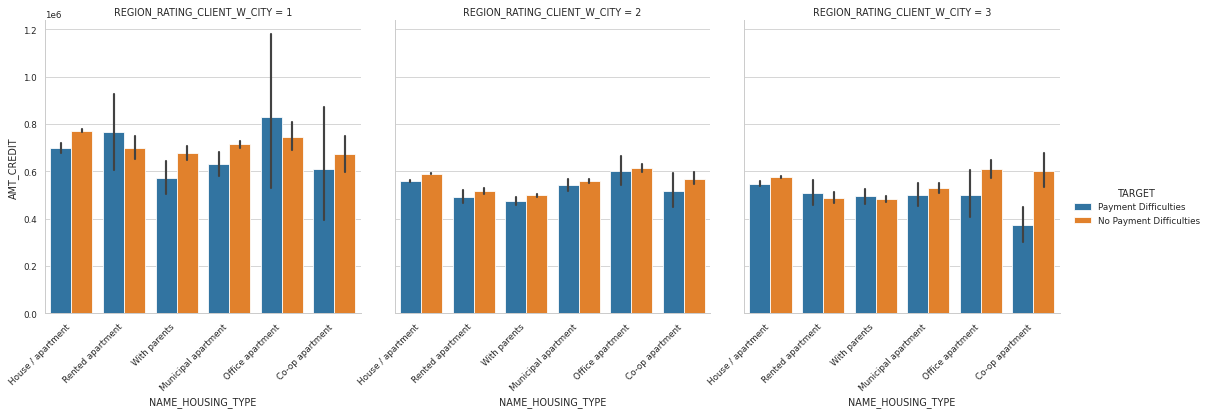

In [63]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT_W_CITY', 
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients who live in rented apartments and office apartments and the area has a rating of 1, have problems repaying the loan compared to clients in the region with a rating of 2 for the medium credit amount of the loan.

3. Education Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives

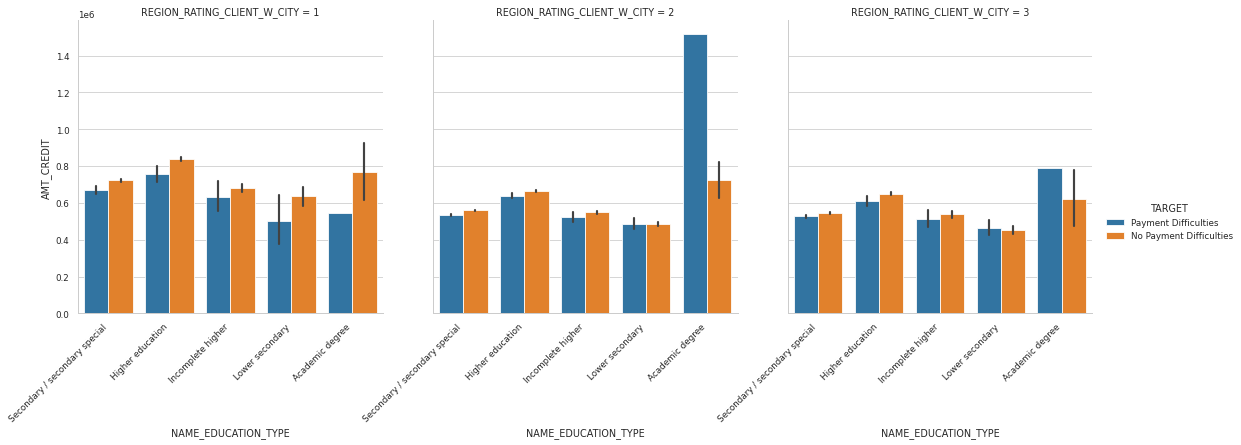

In [64]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT_W_CITY', 
            kind = 'bar',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

For clients who have an academic degree and live in an area with a rating of 2, have problems repaying loans for higher credit amounts. And, clients with the same degree but living in a region with a rating of 3 have problems repaying loans for moderate amounts of loan credit.

# Data Cleaning

### Detecting Data Duplication

In [65]:
print('The number of duplication is:', df_train.duplicated().sum())

The number of duplication is: 0


### Detecting Missing Values

In [66]:
print('Missing values status:', df_train.isnull().values.any())
nvc = pd.DataFrame(df_train.isnull().sum(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MODE,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MEDI,210199,68.354953


In [67]:
# drop features that have large number of missing values (± 50%)
df_train.drop(df_train.iloc[:, 44:91], inplace=True, axis=1)
df_train.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [68]:
# after drop some features
print('Missing values status:', df_train.isnull().values.any())
nvc = pd.DataFrame(df_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,96391,31.345545
1,EXT_SOURCE_3,60965,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
3,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
4,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
5,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631
6,AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
7,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.501631
8,NAME_TYPE_SUITE,1292,0.420148
9,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.332021


# Feature Selection

using model from **`Finlytics Hub`** :
* https://medium.com/towards-data-science/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03

In [69]:
# Change target 0 = bad, 1 = good because in scorecard : higher -> better
df_train['TARGET'] = df_train['TARGET'].apply(lambda x: 1 if x == 0 else 0)

In [70]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = df_train.drop('TARGET', axis = 1)
y = df_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

We do this first, for the sake of simplicty.

In [71]:
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [72]:
print(list(X_train_num.columns))

['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DO

In [73]:
print(list(X_train_cat.columns))

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


Let's do it, one at a time.

## Categorical

In [74]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
# chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result.merge(X_train_cat.describe().T.reset_index(), left_on ='Feature', right_on = 'index').sort_values(by = ['p-value', 'unique'])

,Feature,p-value,index,count,unique,top,freq
0,NAME_CONTRACT_TYPE,0.000000,NAME_CONTRACT_TYPE,246008,2,Cash loans,222521
2,FLAG_OWN_CAR,0.000000,FLAG_OWN_CAR,246008,2,N,162453
1,CODE_GENDER,0.000000,CODE_GENDER,246008,3,F,162038
6,NAME_EDUCATION_TYPE,0.000000,NAME_EDUCATION_TYPE,246008,5,Secondary / secondary special,174765
7,NAME_FAMILY_STATUS,0.000000,NAME_FAMILY_STATUS,246008,6,Married,157064
8,NAME_HOUSING_TYPE,0.000000,NAME_HOUSING_TYPE,246008,6,House / apartment,218329
5,NAME_INCOME_TYPE,0.000000,NAME_INCOME_TYPE,246008,8,Working,127003
9,OCCUPATION_TYPE,0.000000,OCCUPATION_TYPE,168853,18,Laborers,44074
11,ORGANIZATION_TYPE,0.000000,ORGANIZATION_TYPE,246008,58,Business Entity Type 3,54447
4,NAME_TYPE_SUITE,0.000309,NAME_TYPE_SUITE,244958,7,Unaccompanied,198887


How do we pick categorical data?
* Low cardinality (unique)
* No null value
* lowest p-value

Tips: Don't have too much features on Logistic Regression

In [75]:
X_train['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Municipal apartment', 'Rented apartment',
       'With parents', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [76]:
X_train['NAME_INCOME_TYPE'].unique()

array(['Pensioner', 'Commercial associate', 'Working', 'State servant',
       'Student', 'Unemployed', 'Maternity leave', 'Businessman'],
      dtype=object)

In [77]:
selected_cat_cols = ['FLAG_OWN_CAR', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']

In [78]:
X_train[selected_cat_cols].head()

,FLAG_OWN_CAR,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE
246542,N,F,Secondary / secondary special,Married,Pensioner
166649,Y,F,Higher education,Married,Commercial associate
213816,Y,M,Secondary / secondary special,Separated,Commercial associate
255236,N,F,Higher education,Single / not married,Working
254621,Y,M,Secondary / secondary special,Single / not married,Commercial associate


NAME_CONTRACT_TYPE, NAME_HOUSING_TYPE aren't selected because they have 1 variable with too much frequency.

## Numerical

In [79]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num.fillna(X_train_num.median()), y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.merge(X_train_num.describe().T.reset_index(), left_on = 'Numerical_Feature', right_on = 'index').sort_values(['F-Score', 'count'], ascending=False).head(50)

,Numerical_Feature,F-Score,p values,index,count,mean,std,min,25%,50%,75%,max
27,EXT_SOURCE_2,6518.576280,0.000000e+00,EXT_SOURCE_2,245469.0,0.514259,0.191124,8.173617e-08,0.392072,0.565832,0.663627,8.549997e-01
28,EXT_SOURCE_3,5995.804669,0.000000e+00,EXT_SOURCE_3,197141.0,0.510714,0.194946,5.272652e-04,0.370650,0.535276,0.669057,8.960095e-01
7,DAYS_BIRTH,1522.372017,0.000000e+00,DAYS_BIRTH,246008.0,-16029.807331,4359.823101,-2.522900e+04,-19673.000000,-15739.000000,-12410.000000,-7.489000e+03
19,REGION_RATING_CLIENT_W_CITY,913.906244,0.000000e+00,REGION_RATING_CLIENT_W_CITY,246008.0,2.031239,0.502947,1.000000e+00,2.000000,2.000000,2.000000,3.000000e+00
18,REGION_RATING_CLIENT,860.350408,0.000000e+00,REGION_RATING_CLIENT,246008.0,2.052340,0.509193,1.000000e+00,2.000000,2.000000,2.000000,3.000000e+00
33,DAYS_LAST_PHONE_CHANGE,767.742734,0.000000e+00,DAYS_LAST_PHONE_CHANGE,246007.0,-963.105456,827.031758,-4.292000e+03,-1570.000000,-757.000000,-274.000000,0.000000e+00
10,DAYS_ID_PUBLISH,674.965486,0.000000e+00,DAYS_ID_PUBLISH,246008.0,-2993.689616,1509.386678,-7.197000e+03,-4298.000000,-3256.000000,-1716.000000,0.000000e+00
25,REG_CITY_NOT_WORK_CITY,630.086032,0.000000e+00,REG_CITY_NOT_WORK_CITY,246008.0,0.230395,0.421086,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
12,FLAG_EMP_PHONE,512.340368,0.000000e+00,FLAG_EMP_PHONE,246008.0,0.820290,0.383946,0.000000e+00,1.000000,1.000000,1.000000,1.000000e+00
35,FLAG_DOCUMENT_3,496.920318,0.000000e+00,FLAG_DOCUMENT_3,246008.0,0.709623,0.453937,0.000000e+00,0.000000,1.000000,1.000000,1.000000e+00


EXT_SOURCE -> External source's score.

In [80]:
temp_num_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'REG_CITY_NOT_WORK_CITY', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 
                 'REG_CITY_NOT_LIVE_CITY', 'DAYS_EMPLOYED', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 
                 'FLAG_DOCUMENT_6', 'CNT_CHILDREN']

In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity

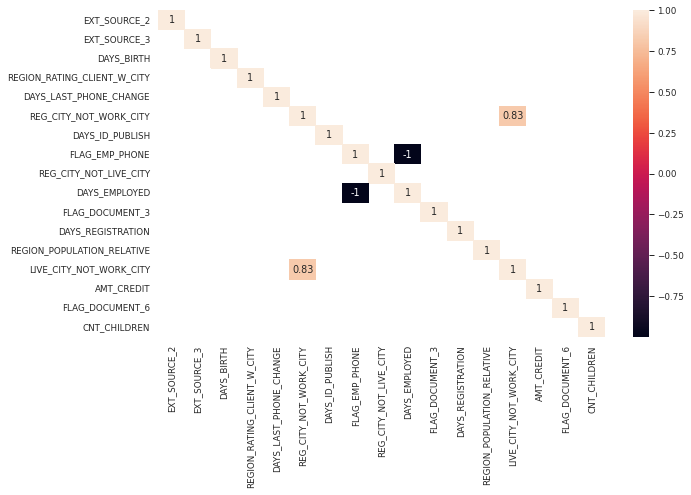

In [81]:
var_corr = X_train[temp_num_cols].corr()
fig = plt.figure(figsize = (10,6))
sns.heatmap(var_corr, annot=True, mask = (abs(var_corr) <= 0.7))

In [82]:
selected_num_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_LIVE_CITY', 'DAYS_EMPLOYED', 
                 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 'LIVE_CITY_NOT_WORK_CITY', 'AMT_CREDIT', 'FLAG_DOCUMENT_6', 'CNT_CHILDREN']

In [83]:
X_train[selected_num_cols].head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_LIVE_CITY,DAYS_EMPLOYED,FLAG_DOCUMENT_3,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,AMT_CREDIT,FLAG_DOCUMENT_6,CNT_CHILDREN
246542,0.391577,0.413597,-19980,2,-1591.0,-3270,0,365243,1,-7521.0,0.011703,0,127350.0,0,0
166649,0.707909,0.633032,-16598,1,-856.0,-129,0,-298,0,-7925.0,0.072508,0,1227901.5,0,0
213816,0.667288,0.466864,-21515,2,-650.0,-4028,0,-2174,1,-629.0,0.019101,0,1215000.0,0,0
255236,0.708474,NaN,-13342,1,-3.0,-916,0,-5943,1,-7252.0,0.072508,0,450000.0,0,0
254621,0.595523,0.448962,-15974,3,-853.0,-568,0,-1130,1,-217.0,0.003122,0,545040.0,0,0


For this numerical data, we will impute / clean with median, for simplicity.

In [84]:
X_train[selected_num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 246542 to 154255
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EXT_SOURCE_2                 245469 non-null  float64
 1   EXT_SOURCE_3                 197141 non-null  float64
 2   DAYS_BIRTH                   246008 non-null  int64  
 3   REGION_RATING_CLIENT_W_CITY  246008 non-null  int64  
 4   DAYS_LAST_PHONE_CHANGE       246007 non-null  float64
 5   DAYS_ID_PUBLISH              246008 non-null  int64  
 6   REG_CITY_NOT_LIVE_CITY       246008 non-null  int64  
 7   DAYS_EMPLOYED                246008 non-null  int64  
 8   FLAG_DOCUMENT_3              246008 non-null  int64  
 9   DAYS_REGISTRATION            246008 non-null  float64
 10  REGION_POPULATION_RELATIVE   246008 non-null  float64
 11  LIVE_CITY_NOT_WORK_CITY      246008 non-null  int64  
 12  AMT_CREDIT                   246008 non-null  float64

In [85]:
selected_cols = selected_cat_cols + selected_num_cols

In [86]:
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

In [87]:
from sklearn.impute import SimpleImputer

numimputer = SimpleImputer(strategy = 'median')

In [88]:
X_train[selected_num_cols] = numimputer.fit_transform(X_train[selected_num_cols])
X_test[selected_num_cols] = numimputer.transform(X_test[selected_num_cols])

In [89]:
def dummy_creation(df, cols):
    df_dummies = pd.get_dummies(df[cols], prefix_sep = ':')
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [90]:
X_train = dummy_creation(X_train, selected_cat_cols)
X_test = dummy_creation(X_test, selected_cat_cols)

In [91]:
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

# WoE Binning / Feature Engineering

In [92]:
pd.DataFrame({'Information Value': ['< 0.02', '0.02 - 0.1', '0.1 - 0.3', '0.3 - 0.5', '> 0.5'],
'Variable Predictiveness' : ['Not useful for prediction','Weak predictive power','Medium Predictive Power','Strong predictive power','suspicious predictive power']})

,Information Value,Variable Predictiveness
0,< 0.02,Not useful for prediction
1,0.02 - 0.1,Weak predictive power
2,0.1 - 0.3,Medium Predictive Power
3,0.3 - 0.5,Strong predictive power
4,> 0.5,suspicious predictive power


In [93]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

## Categorical

In [94]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index=False).agg({df.columns[1]: ['count', 'sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_bad']
    df['n_good'] = df['n_obs'] - df['n_bad']
    
    # WOE
    df['total_dist'] = df['n_obs'] / df['n_obs'].sum()
    df['bad_dist'] = df['n_bad'] / df['n_bad'].sum()
    df['good_dist'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['good_dist'] / df['bad_dist'])
    df = df.sort_values(['WoE'])
    
    # IV 
    df['IV'] = (df['good_dist'] - df['bad_dist']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [95]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    plt.figure(figsize=(18, 6))
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    sns.lineplot(x = x, y = y, marker = 'o', linestyle = ':', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)
    plt.show()

In [96]:
selected_cat_cols

['FLAG_OWN_CAR',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_INCOME_TYPE']

**FLAG_OWN_CAR**

In [97]:
df_temp = woe_discrete(X_train_prepr, 'FLAG_OWN_CAR', y_train_prepr)
df_temp

,FLAG_OWN_CAR,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
1,Y,83555,77536,6019,0.339643,0.342855,0.303072,-0.123339,0.007245
0,N,162453,148612,13841,0.660357,0.657145,0.696928,0.058778,0.007245


IV < 0.02 = Not useful for prediction

**CODE_GENDER**

In [98]:
df_temp = woe_discrete(X_train_prepr, 'CODE_GENDER', y_train_prepr)
df_temp

,CODE_GENDER,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
2,XNA,2,2,0,0.000008,0.000009,0.000000,-inf,inf
0,F,162038,150670,11368,0.658670,0.666245,0.572407,-0.151808,inf
1,M,83968,75476,8492,0.341322,0.333746,0.427593,0.247792,inf


Problem: XNA

Simple `temporary` solution until we have much more data on XNA -> change XNA to female....

In [99]:
X_train_prepr['CODE_GENDER'] = X_train_prepr['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

In [100]:
df_temp = woe_discrete(X_train_prepr, 'CODE_GENDER', y_train_prepr)
df_temp

,CODE_GENDER,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,F,162040,150672,11368,0.658678,0.666254,0.572407,-0.151821,0.037502
1,M,83968,75476,8492,0.341322,0.333746,0.427593,0.247792,0.037502


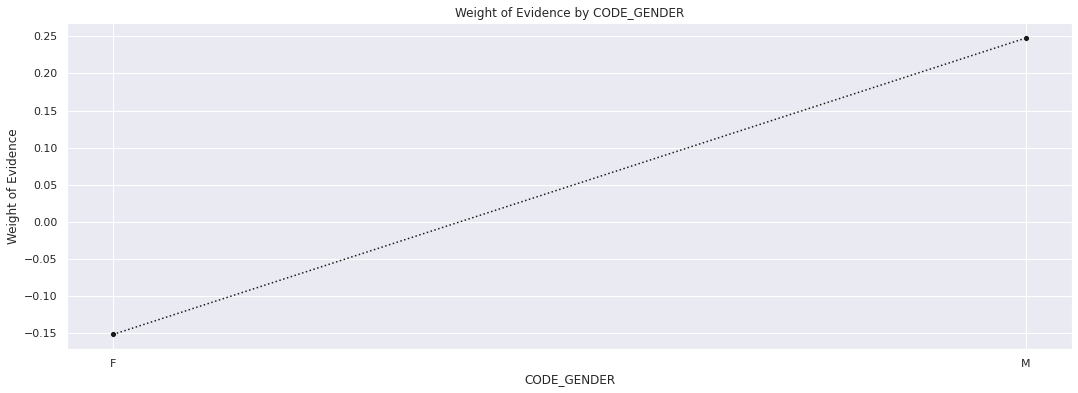

In [101]:
plot_by_woe(df_temp)

**NAME_EDUCATION_TYPE**

In [102]:
df_temp = woe_discrete(X_train_prepr, 'NAME_EDUCATION_TYPE', y_train_prepr)
df_temp

,NAME_EDUCATION_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,Academic degree,124,121,3,0.000504,0.000535,0.000151,-1.264696,0.048773
1,Higher education,59829,56594,3235,0.243199,0.250252,0.162890,-0.429392,0.048773
2,Incomplete higher,8260,7547,713,0.033576,0.033372,0.035901,0.073058,0.048773
4,Secondary / secondary special,174765,159199,15566,0.710404,0.703959,0.783787,0.107416,0.048773
3,Lower secondary,3030,2687,343,0.012317,0.011882,0.017271,0.374032,0.048773


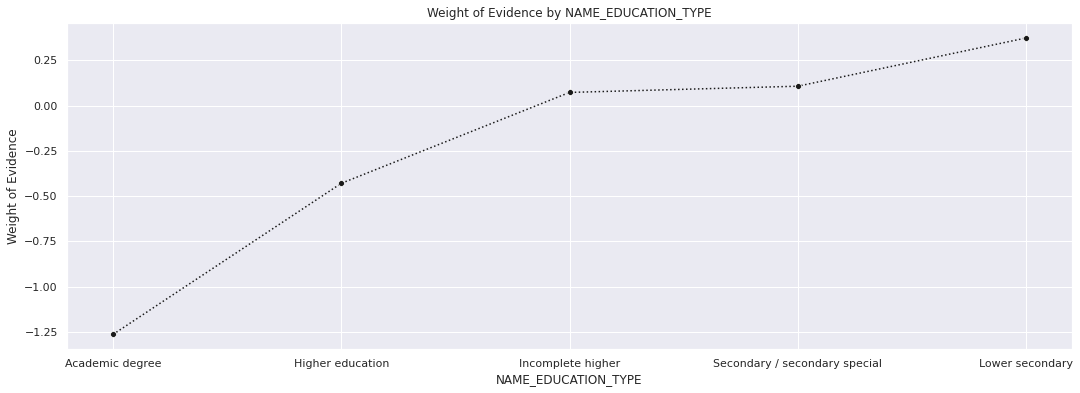

In [103]:
plot_by_woe(df_temp)

**NAME_FAMILY_STATUS**

In [104]:
df_temp = woe_discrete(X_train_prepr, 'NAME_FAMILY_STATUS', y_train_prepr)
df_temp

,NAME_FAMILY_STATUS,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
4,Unknown,1,1,0,0.000004,0.000004,0.000000,-inf,inf
5,Widow,12846,12102,744,0.052218,0.053514,0.037462,-0.356603,inf
1,Married,157064,145177,11887,0.638451,0.641956,0.598540,-0.070026,inf
2,Separated,15853,14568,1285,0.064441,0.064418,0.064703,0.004413,inf
3,Single / not married,36380,32817,3563,0.147881,0.145113,0.179406,0.212138,inf
0,Civil marriage,23864,21483,2381,0.097005,0.094995,0.119889,0.232741,inf


Problem: Unknown

Simple `temporary` solution until we have much more data on Unknown -> change Unknown to single....

In [105]:
X_train_prepr['NAME_FAMILY_STATUS'] = X_train_prepr['NAME_FAMILY_STATUS'].apply(lambda x: 'Single / not married' if x == 'Unknown' else x)

In [106]:
df_temp = woe_discrete(X_train_prepr, 'NAME_FAMILY_STATUS', y_train_prepr)
df_temp

,NAME_FAMILY_STATUS,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
4,Widow,12846,12102,744,0.052218,0.053514,0.037462,-0.356603,0.021832
1,Married,157064,145177,11887,0.638451,0.641956,0.598540,-0.070026,0.021832
2,Separated,15853,14568,1285,0.064441,0.064418,0.064703,0.004413,0.021832
3,Single / not married,36381,32818,3563,0.147885,0.145117,0.179406,0.212108,0.021832
0,Civil marriage,23864,21483,2381,0.097005,0.094995,0.119889,0.232741,0.021832


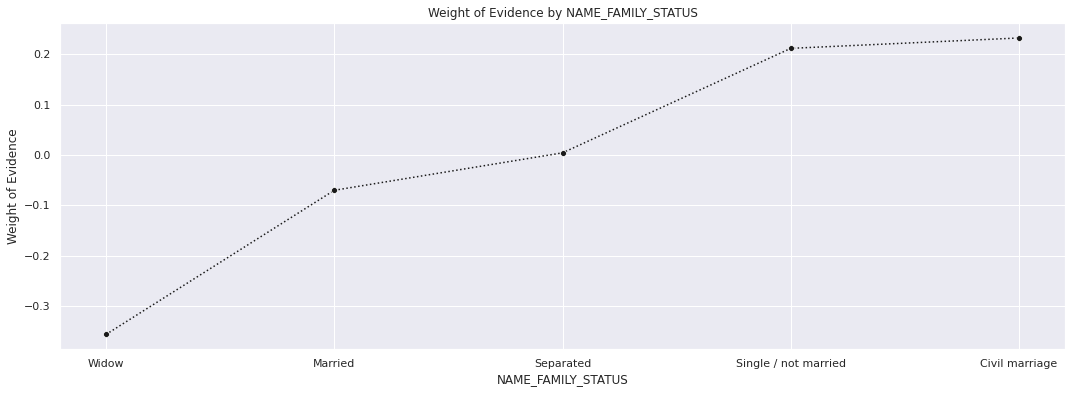

In [107]:
plot_by_woe(df_temp)

**NAME_INCOME_TYPE**

In [108]:
df_temp = woe_discrete(X_train_prepr, 'NAME_INCOME_TYPE', y_train_prepr)
df_temp

,NAME_INCOME_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,Businessman,9,9,0,0.000037,0.000040,0.000000,-inf,inf
5,Student,12,12,0,0.000049,0.000053,0.000000,-inf,inf
3,Pensioner,44190,41800,2390,0.179628,0.184835,0.120342,-0.429121,inf
4,State servant,17505,16518,987,0.071156,0.073041,0.049698,-0.385054,inf
1,Commercial associate,57266,52972,4294,0.232781,0.234236,0.216213,-0.080063,inf
7,Working,127003,114821,12182,0.516256,0.507725,0.613394,0.189067,inf
6,Unemployed,18,13,5,0.000073,0.000057,0.000252,1.476971,inf
2,Maternity leave,5,3,2,0.000020,0.000013,0.000101,2.027017,inf


Problem: Businessman, Maternity leave, Student

Simple `temporary` solution until we have much more data on Businessman, Maternity leave, Student:
* Change Businessman to Commercial associate
* Change maternity leave to Pensioner
* Change student to Unemployed

In [109]:
def nameincometype(ityp):
    if ityp == 'Businessman':
        return 'Commercial associate'
    elif ityp == 'Maternity leave':
        return 'Pensioner'
    elif ityp == 'Student':
        return 'Unemployed'
    else: 
        return ityp

In [110]:
X_train_prepr['NAME_INCOME_TYPE'] = X_train_prepr['NAME_INCOME_TYPE'].apply(nameincometype)

In [111]:
df_temp = woe_discrete(X_train_prepr, 'NAME_INCOME_TYPE', y_train_prepr)
df_temp

,NAME_INCOME_TYPE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
1,Pensioner,44195,41803,2392,0.179649,0.184848,0.120443,-0.428356,0.05812
2,State servant,17505,16518,987,0.071156,0.073041,0.049698,-0.385054,0.05812
0,Commercial associate,57275,52981,4294,0.232818,0.234276,0.216213,-0.080233,0.05812
4,Working,127003,114821,12182,0.516256,0.507725,0.613394,0.189067,0.05812
3,Unemployed,30,25,5,0.000122,0.000111,0.000252,0.823044,0.05812


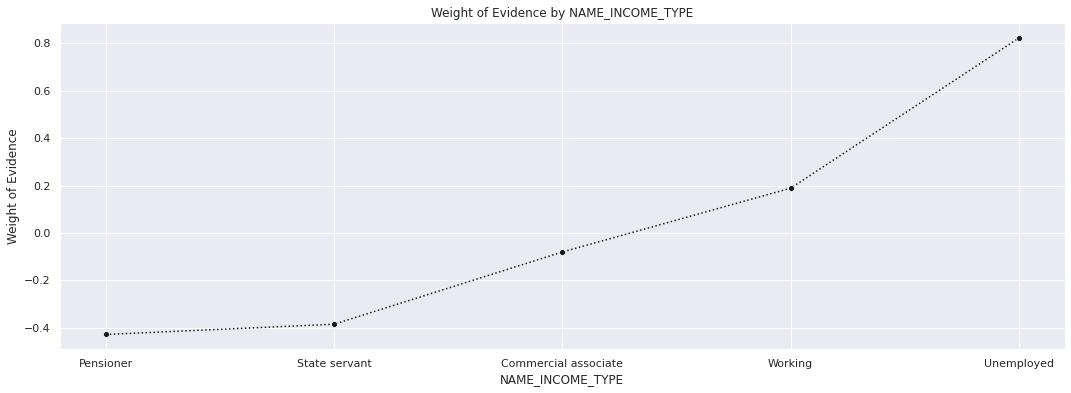

In [112]:
plot_by_woe(df_temp)

## Numerical

In [113]:
X_train_prepr[selected_num_cols].nunique().sort_values()

REG_CITY_NOT_LIVE_CITY              2
FLAG_DOCUMENT_3                     2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_6                     2
REGION_RATING_CLIENT_W_CITY         3
CNT_CHILDREN                       14
REGION_POPULATION_RELATIVE         81
EXT_SOURCE_3                      806
DAYS_LAST_PHONE_CHANGE           3737
AMT_CREDIT                       5289
DAYS_ID_PUBLISH                  6144
DAYS_EMPLOYED                   12057
DAYS_REGISTRATION               15417
DAYS_BIRTH                      17412
EXT_SOURCE_2                   108834
dtype: int64

In [114]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = df.groupby(cat_variable_name, as_index=False).agg({df.columns[1]: ['count', 'sum']})
    df.columns = [cat_variable_name, 'n_obs', 'n_bad']
    df['n_good'] = df['n_obs'] - df['n_bad']
    
    # WOE
    df['total_dist'] = df['n_obs'] / df['n_obs'].sum()
    df['bad_dist'] = df['n_bad'] / df['n_bad'].sum()
    df['good_dist'] = df['n_good'] / df['n_good'].sum()
    df['WoE'] = np.log(df['good_dist'] / df['bad_dist'])
    #df = df.sort_values(['WoE'])
    
    # IV 
    df['IV'] = (df['good_dist'] - df['bad_dist']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**REG_CITY_NOT_LIVE_CITY**

In [115]:
df_temp = woe_ordered_continuous(X_train_prepr, 'REG_CITY_NOT_LIVE_CITY', y_train_prepr)
df_temp

,REG_CITY_NOT_LIVE_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,226815,209306,17509,0.921982,0.925527,0.881621,-0.048600,0.022482
1,1.0,19193,16842,2351,0.078018,0.074473,0.118379,0.463447,0.022482


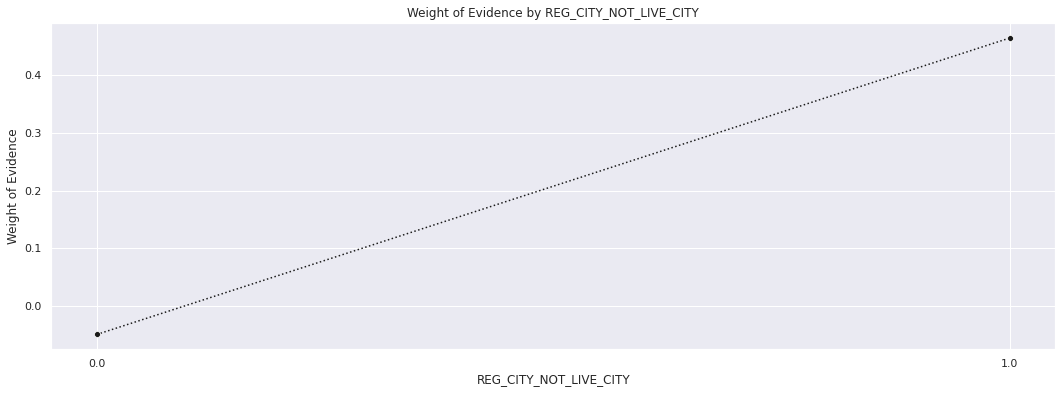

In [116]:
plot_by_woe(df_temp)

**FLAG_DOCUMENT_3**

In [117]:
df_temp = woe_ordered_continuous(X_train_prepr, 'FLAG_DOCUMENT_3', y_train_prepr)
df_temp

,FLAG_DOCUMENT_3,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,71435,67034,4401,0.290377,0.296417,0.221601,-0.290886,0.029323
1,1.0,174573,159114,15459,0.709623,0.703583,0.778399,0.101052,0.029323


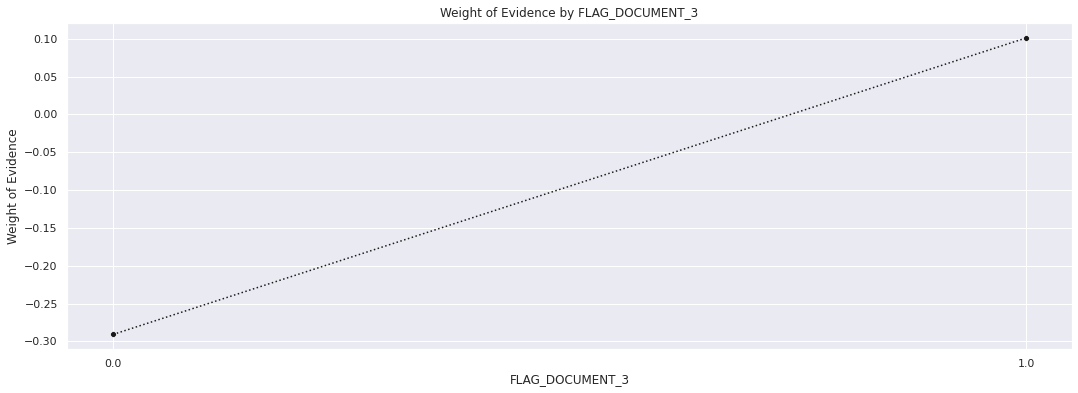

In [118]:
plot_by_woe(df_temp)

**LIVE_CITY_NOT_WORK_CITY**

In [119]:
df_temp = woe_ordered_continuous(X_train_prepr, 'LIVE_CITY_NOT_WORK_CITY', y_train_prepr)
df_temp

,LIVE_CITY_NOT_WORK_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,201813,186319,15494,0.820351,0.823881,0.780161,-0.054525,0.012078
1,1.0,44195,39829,4366,0.179649,0.176119,0.219839,0.221734,0.012078


IV < 0.02

**FLAG_DOCUMENT_6**

In [120]:
df_temp = woe_ordered_continuous(X_train_prepr, 'FLAG_DOCUMENT_6', y_train_prepr)
df_temp

,FLAG_DOCUMENT_6,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,224339,205678,18661,0.911917,0.909484,0.939627,0.032606,0.013191
1,1.0,21669,20470,1199,0.088083,0.090516,0.060373,-0.404991,0.013191


IV < 0.02

**REGION_RATING_CLIENT_W_CITY**

In [121]:
df_temp = woe_ordered_continuous(X_train_prepr, 'REGION_RATING_CLIENT_W_CITY', y_train_prepr)
df_temp

,REGION_RATING_CLIENT_W_CITY,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,1.0,27392,26071,1321,0.111346,0.115283,0.066516,-0.549953,0.051268
1,2.0,183539,168992,14547,0.746069,0.747263,0.732477,-0.019985,0.051268
2,3.0,35077,31085,3992,0.142585,0.137454,0.201007,0.380049,0.051268


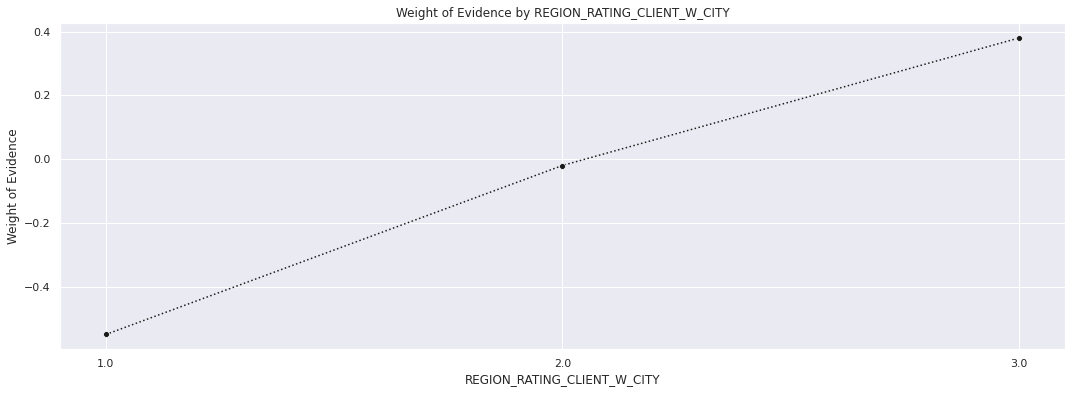

In [122]:
plot_by_woe(df_temp)

**CNT_CHILDREN**

In [123]:
df_temp = woe_ordered_continuous(X_train_prepr, 'CNT_CHILDREN', y_train_prepr)
df_temp

,CNT_CHILDREN,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,172178,158937,13241,0.699888,0.702801,0.666717,-0.052708,inf
1,1.0,49013,44591,4422,0.199233,0.197176,0.222659,0.121542,inf
2,2.0,21440,19567,1873,0.087152,0.086523,0.094310,0.086179,inf
3,3.0,2940,2673,267,0.011951,0.011820,0.013444,0.128774,inf
4,4.0,327,284,43,0.001329,0.001256,0.002165,0.544708,inf
5,5.0,75,69,6,0.000305,0.000305,0.000302,-0.009865,inf
6,6.0,18,12,6,0.000073,0.000053,0.000302,1.739335,inf
7,7.0,6,6,0,0.000024,0.000027,0.000000,-inf,inf
8,8.0,2,2,0,0.000008,0.000009,0.000000,-inf,inf
9,9.0,1,0,1,0.000004,0.000000,0.000050,inf,inf


Problem: children count: 7,8,10,12,14,19

I think we should remove children > 6...

In [124]:
X_train_prepr_temp = X_train_prepr[X_train_prepr['CNT_CHILDREN'] <= 6].copy()

df_temp = woe_ordered_continuous(X_train_prepr_temp, 'CNT_CHILDREN', y_train_prepr)
df_temp

,CNT_CHILDREN,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,0.0,172178,158937,13241,0.699936,0.702847,0.666784,-0.052673,0.006808
1,1.0,49013,44591,4422,0.199247,0.197189,0.222681,0.121576,0.006808
2,2.0,21440,19567,1873,0.087158,0.086529,0.094320,0.086213,0.006808
3,3.0,2940,2673,267,0.011952,0.011820,0.013445,0.128808,0.006808
4,4.0,327,284,43,0.001329,0.001256,0.002165,0.544742,0.006808
5,5.0,75,69,6,0.000305,0.000305,0.000302,-0.009831,0.006808
6,6.0,18,12,6,0.000073,0.000053,0.000302,1.739369,0.006808


Very low IV though.

**REGION_POPULATION_RELATIVE**

In [125]:
# fine-classing
X_train_prepr['REGION_POPULATION_RELATIVE_factor'] = pd.cut(X_train_prepr['REGION_POPULATION_RELATIVE'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'REGION_POPULATION_RELATIVE_factor', y_train_prepr)
df_temp

,REGION_POPULATION_RELATIVE_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(0.000218, 0.0147]",90449,82858,7591,0.367667,0.366388,0.382226,0.042317,0.026641
1,"(0.0147, 0.0292]",100843,92053,8790,0.409918,0.407048,0.442598,0.083732,0.026641
2,"(0.0292, 0.0436]",37197,34520,2677,0.151202,0.152643,0.134794,-0.124360,0.026641
3,"(0.0436, 0.0581]",10829,10299,530,0.044019,0.045541,0.026687,-0.534443,0.026641
4,"(0.0581, 0.0725]",6690,6418,272,0.027194,0.028380,0.013696,-0.728578,0.026641


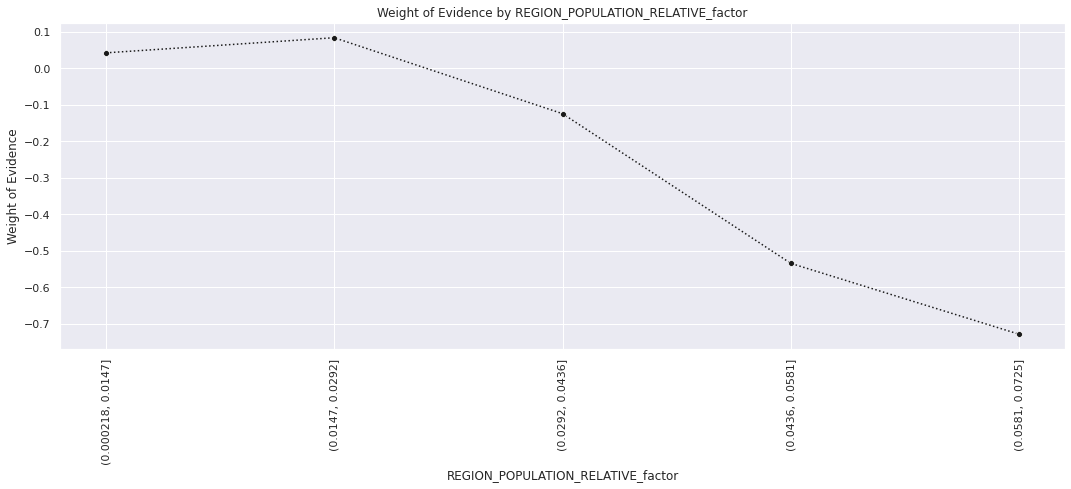

In [126]:
plot_by_woe(df_temp,90)

**DAYS_LAST_PHONE_CHANGE**

In [127]:
# Very rough binning for days -> to year
def toyear(series):
    return -np.floor((series/365))

In [128]:
# fine-classing
X_train_prepr['YEAR_LAST_PHONE_CHANGE'] = toyear(X_train_prepr['DAYS_LAST_PHONE_CHANGE'])
X_train_prepr['YEAR_LAST_PHONE_CHANGE'] = pd.cut(X_train_prepr['YEAR_LAST_PHONE_CHANGE'], 6)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_LAST_PHONE_CHANGE', y_train_prepr)
df_temp

,YEAR_LAST_PHONE_CHANGE,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.012, 2.0]",120240,108831,11409,0.488765,0.481238,0.574471,0.177088,0.046062
1,"(2.0, 4.0]",54154,49975,4179,0.220131,0.220984,0.210423,-0.048969,0.046062
2,"(4.0, 6.0]",48138,45116,3022,0.195677,0.199498,0.152165,-0.270836,0.046062
3,"(6.0, 8.0]",18782,17747,1035,0.076347,0.078475,0.052115,-0.409333,0.046062
4,"(8.0, 10.0]",4515,4308,207,0.018353,0.019049,0.010423,-0.603028,0.046062
5,"(10.0, 12.0]",179,171,8,0.000728,0.000756,0.000403,-0.629740,0.046062


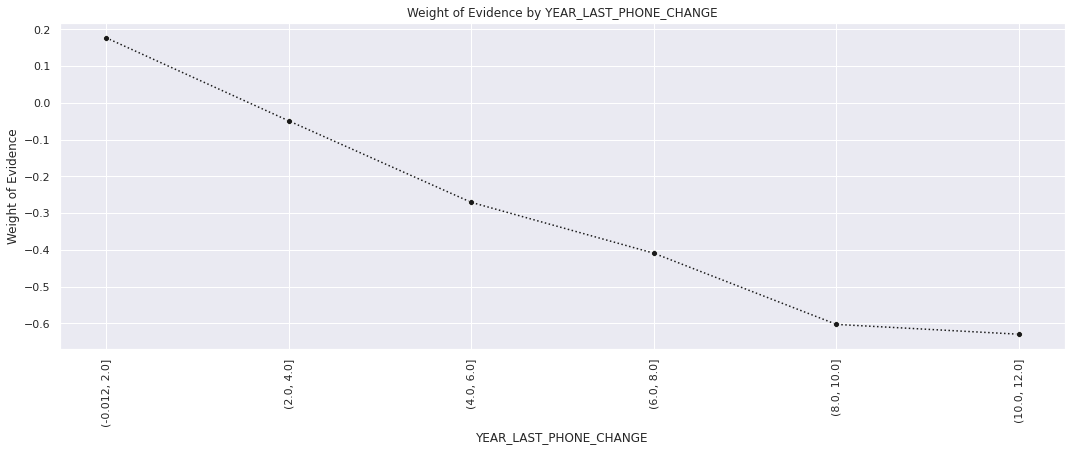

In [129]:
plot_by_woe(df_temp,90)

**AMT_CREDIT**

In [130]:
# fine-classing
X_train_prepr['AMT_CREDIT_factor'] = pd.cut(X_train_prepr['AMT_CREDIT'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'AMT_CREDIT_factor', y_train_prepr)
df_temp

,AMT_CREDIT_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(40995.0, 846000.0]",190293,173858,16435,0.773524,0.768780,0.827543,0.073656,0.024318
1,"(846000.0, 1647000.0]",50714,47498,3216,0.206148,0.210031,0.161934,-0.260067,0.024318
2,"(1647000.0, 2448000.0]",4666,4470,196,0.018967,0.019766,0.009869,-0.694547,0.024318
3,"(2448000.0, 3249000.0]",317,305,12,0.001289,0.001349,0.000604,-0.802923,0.024318
4,"(3249000.0, 4050000.0]",18,17,1,0.000073,0.000075,0.000050,-0.400731,0.024318


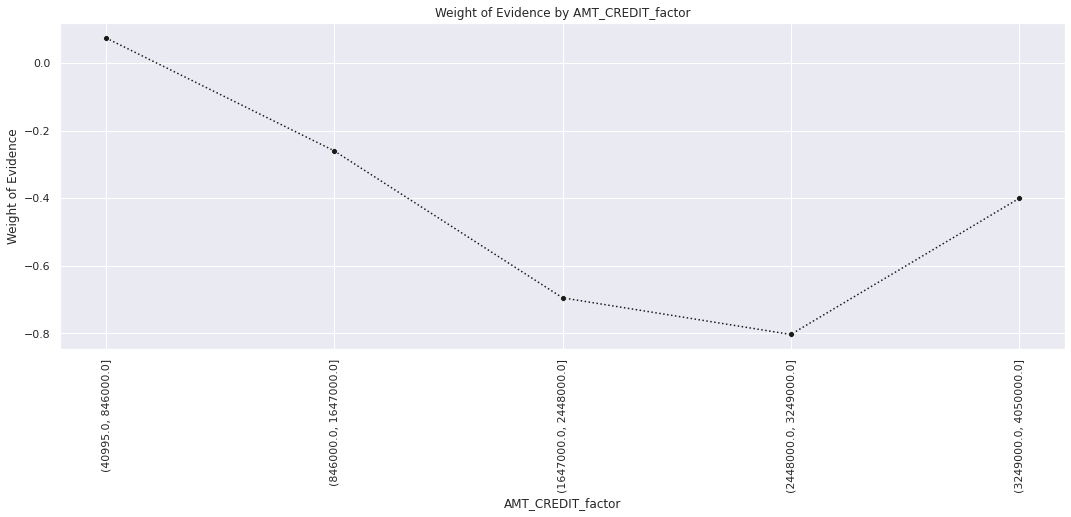

In [131]:
plot_by_woe(df_temp,90)

**DAYS_ID_PUBLISH**

In [132]:
# fine-classing
X_train_prepr['YEAR_ID_PUBLISH'] = toyear(X_train_prepr['DAYS_ID_PUBLISH'])
X_train_prepr['YEAR_ID_PUBLISH'] = pd.cut(X_train_prepr['YEAR_ID_PUBLISH'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_ID_PUBLISH', y_train_prepr)
df_temp

,YEAR_ID_PUBLISH,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.02, 4.0]",52241,46992,5249,0.212355,0.207793,0.264300,0.240542,0.035895
1,"(4.0, 8.0]",57096,52002,5094,0.232090,0.229947,0.256495,0.109263,0.035895
2,"(8.0, 12.0]",82861,76633,6228,0.336822,0.338862,0.313595,-0.077491,0.035895
3,"(12.0, 16.0]",53105,49850,3255,0.215867,0.220431,0.163897,-0.296344,0.035895
4,"(16.0, 20.0]",705,671,34,0.002866,0.002967,0.001712,-0.549927,0.035895


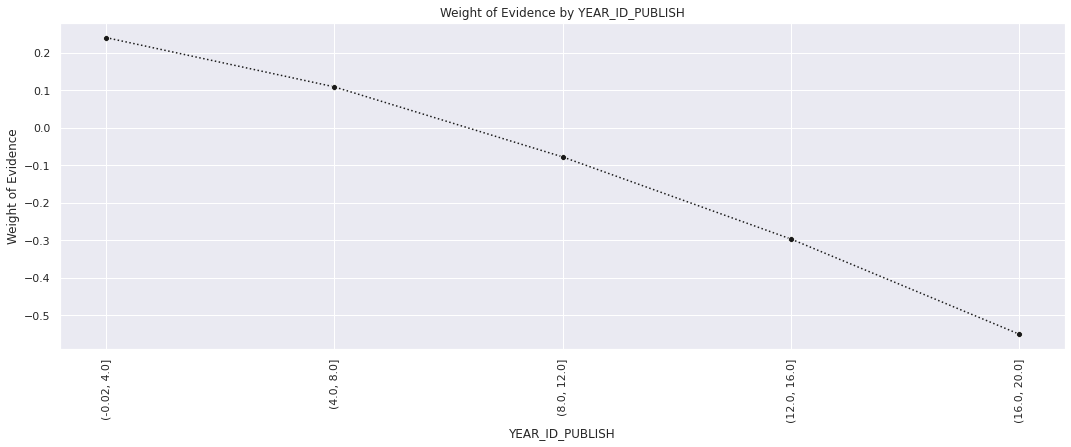

In [133]:
plot_by_woe(df_temp,90)

**DAYS_EMPLOYED**

In [134]:
# fine-classing
X_train_prepr['YEAR_EMPLOYED'] = toyear(X_train_prepr['DAYS_EMPLOYED'])
X_train_prepr['YEAR_EMPLOYED'] = pd.cut(X_train_prepr['YEAR_EMPLOYED'], 2)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_EMPLOYED', y_train_prepr)
df_temp

,YEAR_EMPLOYED,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-1001.049, -475.5]",44200,41805,2395,0.179669,0.184857,0.120594,-0.427151,0.032326
1,"(-475.5, 49.0]",201808,184343,17465,0.820331,0.815143,0.879406,0.075883,0.032326


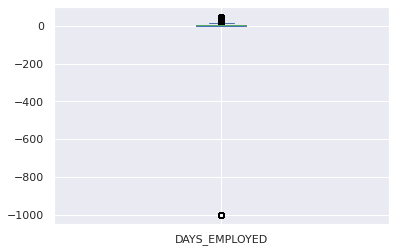

In [135]:
toyear(X_train_prepr['DAYS_EMPLOYED']).plot(kind='box')

I don't understand this feature...... Days employed,some < 0, some > 0 ? With high number of observation too?

Won't be used for now

**DAYS_REGISTRATION**

In [136]:
# fine-classing
X_train_prepr['YEAR_REGISTRATION'] = toyear(X_train_prepr['DAYS_REGISTRATION'])
X_train_prepr['YEAR_REGISTRATION'] = pd.cut(X_train_prepr['YEAR_REGISTRATION'], 4)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_REGISTRATION', y_train_prepr)
df_temp

,YEAR_REGISTRATION,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.068, 17.0]",161752,147509,14243,0.657507,0.652268,0.717170,0.094858,0.021206
1,"(17.0, 34.0]",76957,71726,5231,0.312823,0.317164,0.263394,-0.185769,0.021206
2,"(34.0, 51.0]",7246,6862,384,0.029454,0.030343,0.019335,-0.450630,0.021206
3,"(51.0, 68.0]",53,51,2,0.000215,0.000226,0.000101,-0.806196,0.021206


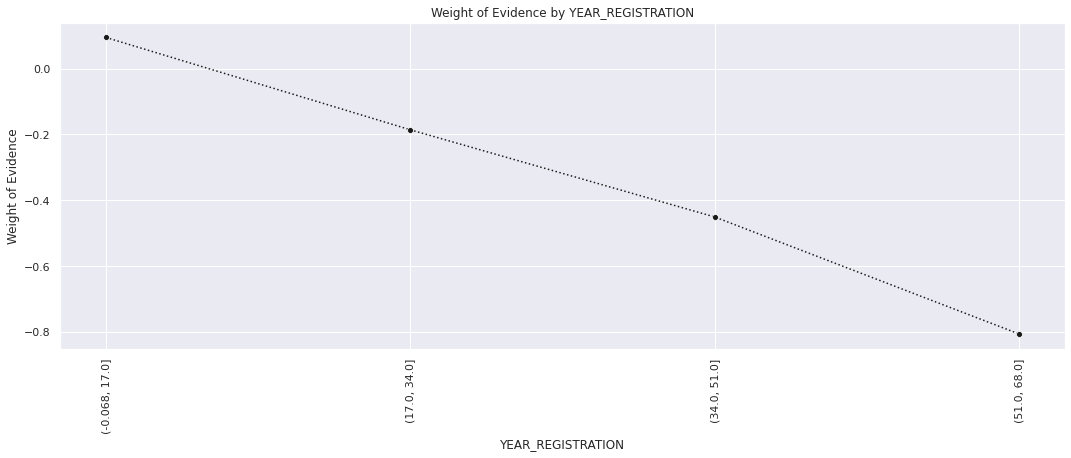

In [137]:
plot_by_woe(df_temp,90)

**DAYS_BIRTH**

In [138]:
# fine-classing
X_train_prepr['YEAR_BIRTH'] = toyear(X_train_prepr['DAYS_BIRTH'])
X_train_prepr['YEAR_BIRTH'] = pd.cut(X_train_prepr['YEAR_BIRTH'], 5)

df_temp = woe_ordered_continuous(X_train_prepr, 'YEAR_BIRTH', y_train_prepr)
df_temp

,YEAR_BIRTH,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(20.951, 30.8]",35997,31868,4129,0.146325,0.140917,0.207905,0.388915,0.080286
1,"(30.8, 40.6]",66020,59711,6309,0.268365,0.264035,0.317674,0.184943,0.080286
2,"(40.6, 50.4]",61326,56619,4707,0.249285,0.250363,0.237009,-0.054812,0.080286
3,"(50.4, 60.2]",54357,51027,3330,0.220956,0.225635,0.167674,-0.296901,0.080286
4,"(60.2, 70.0]",28308,26923,1385,0.115069,0.119050,0.069738,-0.534799,0.080286


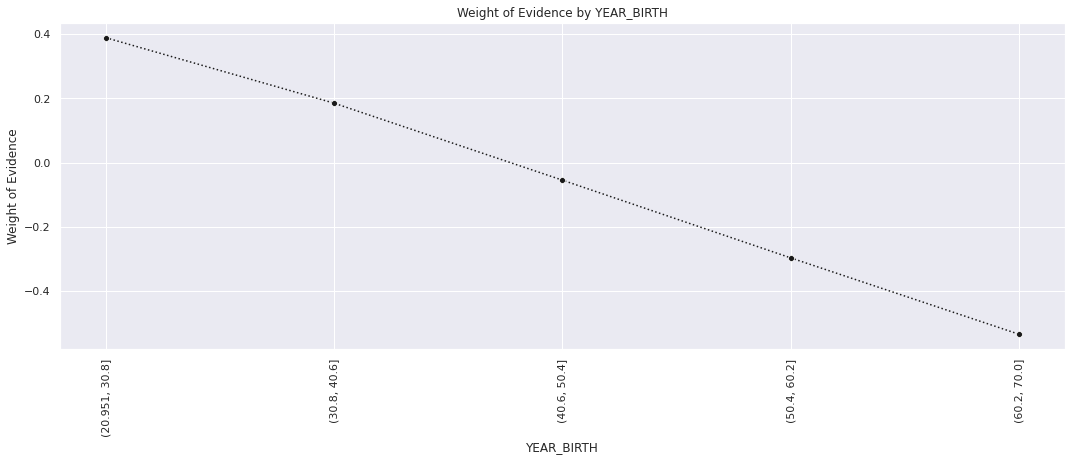

In [139]:
plot_by_woe(df_temp,90)

**EXT_SOURCE_2**

In [140]:
# fine-classing
X_train_prepr['EXT_SOURCE_2_factor'] = pd.cut(X_train_prepr['EXT_SOURCE_2'], 10)

df_temp = woe_ordered_continuous(X_train_prepr, 'EXT_SOURCE_2_factor', y_train_prepr)
df_temp

,EXT_SOURCE_2_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.000855, 0.0855]",7616,5775,1841,0.030958,0.025536,0.092699,1.289253,0.317368
1,"(0.0855, 0.171]",10347,8599,1748,0.042060,0.038024,0.088016,0.839308,0.317368
2,"(0.171, 0.256]",13317,11477,1840,0.054132,0.050750,0.092649,0.601903,0.317368
3,"(0.256, 0.342]",18373,16274,2099,0.074685,0.071962,0.105690,0.384374,0.317368
4,"(0.342, 0.427]",20680,18595,2085,0.084062,0.082225,0.104985,0.244358,0.317368
5,"(0.427, 0.513]",28298,25915,2383,0.115029,0.114593,0.119990,0.046020,0.317368
6,"(0.513, 0.598]",43229,40136,3093,0.175722,0.177477,0.155740,-0.130650,0.317368
7,"(0.598, 0.684]",56324,53224,3100,0.228952,0.235350,0.156093,-0.410625,0.317368
8,"(0.684, 0.769]",42660,41103,1557,0.173409,0.181753,0.078399,-0.840838,0.317368
9,"(0.769, 0.855]",5164,5050,114,0.020991,0.022331,0.005740,-1.358463,0.317368


Feature with strong predictive power, finally. But this will make us dependent to SOURCE 2

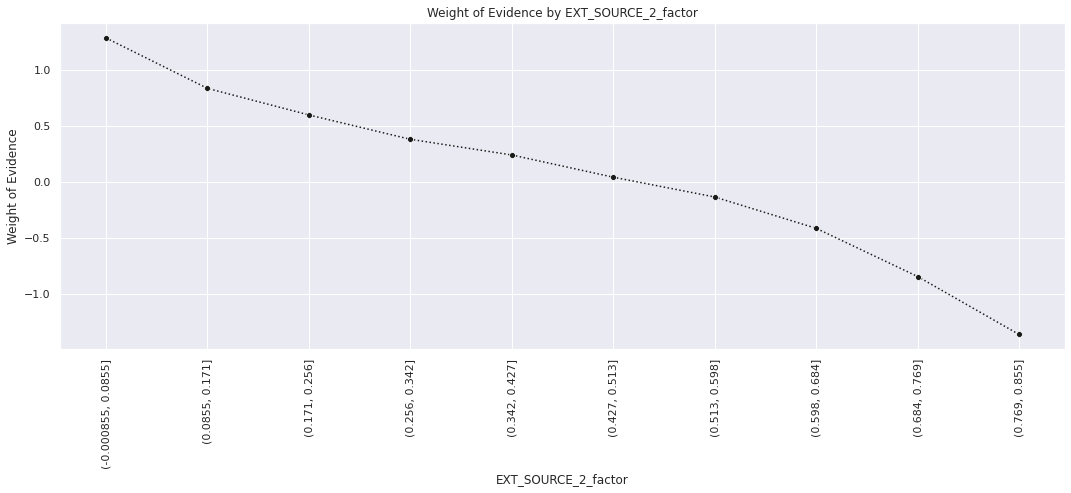

In [141]:
plot_by_woe(df_temp,90)

**EXT_SOURCE_3**

In [142]:
# fine-classing
X_train_prepr['EXT_SOURCE_3_factor'] = pd.cut(X_train_prepr['EXT_SOURCE_3'], 10)

df_temp = woe_ordered_continuous(X_train_prepr, 'EXT_SOURCE_3_factor', y_train_prepr)
df_temp

,EXT_SOURCE_3_factor,n_obs,n_bad,n_good,total_dist,bad_dist,good_dist,WoE,IV
0,"(-0.000368, 0.0901]",3615,2675,940,0.014695,0.011829,0.047331,1.386657,0.320361
1,"(0.0901, 0.18]",9251,7381,1870,0.037604,0.032638,0.094159,1.059511,0.320361
2,"(0.18, 0.269]",13989,11863,2126,0.056864,0.052457,0.107049,0.713300,0.320361
3,"(0.269, 0.359]",19288,17139,2149,0.078404,0.075787,0.108207,0.356128,0.320361
4,"(0.359, 0.448]",24314,22190,2124,0.098834,0.098122,0.106949,0.086141,0.320361
5,"(0.448, 0.538]",77699,71184,6515,0.315839,0.314767,0.328046,0.041321,0.320361
6,"(0.538, 0.627]",32915,31205,1710,0.133796,0.137985,0.086103,-0.471603,0.320361
7,"(0.627, 0.717]",34333,32894,1439,0.139561,0.145453,0.072457,-0.696860,0.320361
8,"(0.717, 0.806]",24437,23638,799,0.099334,0.104524,0.040232,-0.954768,0.320361
9,"(0.806, 0.896]",6167,5979,188,0.025068,0.026438,0.009466,-1.027085,0.320361


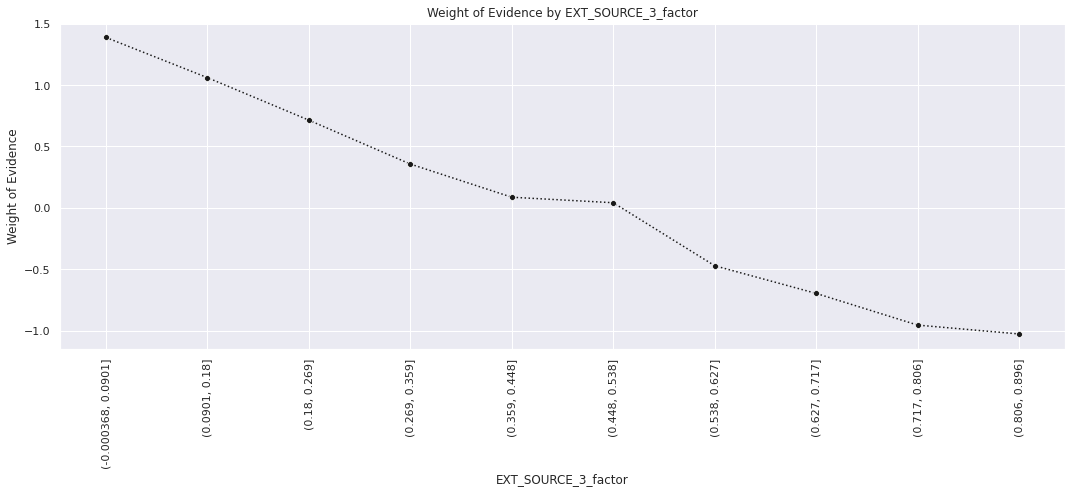

In [143]:
plot_by_woe(df_temp,90)

## Define Custom Class for WoE Binning/Reengineering

In [144]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'CODE_GENDER:M'].to_frame()
        X_new['CODE_GENDER:F_XNA'] = sum([X['CODE_GENDER:F'], X['CODE_GENDER:XNA']])

        X_new['NAME_EDUCATION_TYPE:Academic degree'] = X.loc[:,'NAME_EDUCATION_TYPE:Academic degree']
        X_new['NAME_EDUCATION_TYPE:Higher education'] = X.loc[:,'NAME_EDUCATION_TYPE:Higher education']
        X_new['NAME_EDUCATION_TYPE:Incomplete higher'] = X.loc[:,'NAME_EDUCATION_TYPE:Incomplete higher']
        X_new['NAME_EDUCATION_TYPE:Lower secondary'] = X.loc[:,'NAME_EDUCATION_TYPE:Lower secondary']
        X_new['NAME_EDUCATION_TYPE:Secondary / secondary special'] = X.loc[:,'NAME_EDUCATION_TYPE:Secondary / secondary special']

        X_new['NAME_FAMILY_STATUS:Single_Unknown'] = X['NAME_FAMILY_STATUS:Single / not married'] | X['NAME_FAMILY_STATUS:Unknown']
        X_new['NAME_FAMILY_STATUS:Civil marriage'] = X.loc[:,'NAME_FAMILY_STATUS:Civil marriage']
        X_new['NAME_FAMILY_STATUS:Married'] = X.loc[:,'NAME_FAMILY_STATUS:Married']
        X_new['NAME_FAMILY_STATUS:Separated'] = X.loc[:,'NAME_FAMILY_STATUS:Separated']
        X_new['NAME_FAMILY_STATUS:Widow'] = X.loc[:,'NAME_FAMILY_STATUS:Widow']

        X_new['NAME_INCOME_TYPE:Business_comm'] = X['NAME_INCOME_TYPE:Businessman'] | X['NAME_INCOME_TYPE:Commercial associate']
        X_new['NAME_INCOME_TYPE:Pensioner_maternity'] = X['NAME_INCOME_TYPE:Pensioner'] | X['NAME_INCOME_TYPE:Maternity leave']
        X_new['NAME_INCOME_TYPE:student_unemployed'] = X['NAME_INCOME_TYPE:Student'] | X['NAME_INCOME_TYPE:Unemployed']
        X_new['NAME_INCOME_TYPE:State servant'] = X.loc[:,'NAME_INCOME_TYPE:State servant']
        X_new['NAME_INCOME_TYPE:Working'] = X.loc[:,'NAME_INCOME_TYPE:Working']

        # numerical
        X_new['REG_CITY_NOT_LIVE_CITY:0'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 0), 1, 0)
        X_new['REG_CITY_NOT_LIVE_CITY:1'] = np.where((X['REG_CITY_NOT_LIVE_CITY'] == 1), 1, 0)

        X_new['FLAG_DOCUMENT_3:0'] = np.where((X['FLAG_DOCUMENT_3'] == 0), 1, 0)
        X_new['FLAG_DOCUMENT_3:1'] = np.where((X['FLAG_DOCUMENT_3'] == 1), 1, 0)

        X_new['REGION_RATING_CLIENT_W_CITY:0'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 0), 1, 0)
        X_new['REGION_RATING_CLIENT_W_CITY:1'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 1), 1, 0)
        X_new['REGION_RATING_CLIENT_W_CITY:2'] = np.where((X['REGION_RATING_CLIENT_W_CITY'] == 2), 1, 0)

        X_new['REGION_POPULATION_RELATIVE:<0.0147'] = np.where((X['REGION_POPULATION_RELATIVE'] <= 0.0147), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0147-0.0292'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0147) & (X['REGION_POPULATION_RELATIVE'] <= 0.0292), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0292-0.0436'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0292) & (X['REGION_POPULATION_RELATIVE'] <= 0.0436), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:0.0436-0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0436) & (X['REGION_POPULATION_RELATIVE'] <= 0.0581), 1, 0)
        X_new['REGION_POPULATION_RELATIVE:>0.0581'] = np.where((X['REGION_POPULATION_RELATIVE'] > 0.0581), 1, 0)

        X_new['YEAR_LAST_PHONE_CHANGE:<2'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 2), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:2-4'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 2) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 4), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:4-6'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 4) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 6), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:6-8'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 6) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 8), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:8-10'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 8) & (-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) <= 10), 1, 0)
        X_new['YEAR_LAST_PHONE_CHANGE:>10'] = np.where((-np.floor(X['DAYS_LAST_PHONE_CHANGE']/365) > 10), 1, 0)

        X_new['AMT_CREDIT:<846000'] = np.where((X['AMT_CREDIT'] <= 846000), 1, 0)
        X_new['AMT_CREDIT:846000-1647000'] = np.where((X['AMT_CREDIT'] > 846000) & (X['AMT_CREDIT'] <= 1647000), 1, 0)
        X_new['AMT_CREDIT:1647000-2448000'] = np.where((X['AMT_CREDIT'] > 1647000) & (X['AMT_CREDIT'] <= 2448000), 1, 0)
        X_new['AMT_CREDIT:2448000-3249000'] = np.where((X['AMT_CREDIT'] > 2448000) & (X['AMT_CREDIT'] <= 3249000), 1, 0)
        X_new['AMT_CREDIT:>3249000'] = np.where((X['AMT_CREDIT'] > 3249000), 1, 0)

        X_new['YEAR_ID_PUBLISH:<4'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) <= 4), 1, 0)
        X_new['YEAR_ID_PUBLISH:4-8'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 4) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 8), 1, 0)
        X_new['YEAR_ID_PUBLISH:8-12'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 8) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 12), 1, 0)
        X_new['YEAR_ID_PUBLISH:12-16'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 12) & (-np.floor(X['DAYS_ID_PUBLISH']/365) <= 16), 1, 0)
        X_new['YEAR_ID_PUBLISH:>16'] = np.where((-np.floor(X['DAYS_ID_PUBLISH']/365) > 16), 1, 0)

        X_new['YEAR_REGISTRATION:<17'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) <= 17), 1, 0)
        X_new['YEAR_REGISTRATION:17-34'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 17) & (-np.floor(X['DAYS_REGISTRATION']/365) <= 34), 1, 0)
        X_new['YEAR_REGISTRATION:34-51'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 34) & (-np.floor(X['DAYS_REGISTRATION']/365) <= 51), 1, 0)
        X_new['YEAR_REGISTRATION:>51'] = np.where((-np.floor(X['DAYS_REGISTRATION']/365) > 51), 1, 0)

        X_new['YEAR_BIRTH:<30'] = np.where((-np.floor(X['DAYS_BIRTH']/365) <= 30), 1, 0)
        X_new['YEAR_BIRTH:30-40'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 30) & (-np.floor(X['DAYS_BIRTH']/365) <= 40), 1, 0)
        X_new['YEAR_BIRTH:40-50'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 40) & (-np.floor(X['DAYS_BIRTH']/365) <= 50), 1, 0)
        X_new['YEAR_BIRTH:50-60'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 50) & (-np.floor(X['DAYS_BIRTH']/365) <= 60), 1, 0)
        X_new['YEAR_BIRTH:>60'] = np.where((-np.floor(X['DAYS_BIRTH']/365) > 60), 1, 0)

        X_new['EXT_SOURCE_2:<0.0855'] = np.where((X['EXT_SOURCE_2'] <= 0.0855), 1, 0)
        X_new['EXT_SOURCE_2:0.0855-0.171'] = np.where((X['EXT_SOURCE_2'] > 0.0855) & (X['EXT_SOURCE_2'] <= 0.171), 1, 0)
        X_new['EXT_SOURCE_2:0.171-0.256'] = np.where((X['EXT_SOURCE_2'] > 0.171) & (X['EXT_SOURCE_2'] <= 0.256), 1, 0)
        X_new['EXT_SOURCE_2:0.256-0.342'] = np.where((X['EXT_SOURCE_2'] > 0.256) & (X['EXT_SOURCE_2'] <= 0.342), 1, 0)
        X_new['EXT_SOURCE_2:0.342-0.427'] = np.where((X['EXT_SOURCE_2'] > 0.342) & (X['EXT_SOURCE_2'] <= 0.427), 1, 0)
        X_new['EXT_SOURCE_2:0.427-0.513'] = np.where((X['EXT_SOURCE_2'] > 0.427) & (X['EXT_SOURCE_2'] <= 0.513), 1, 0)
        X_new['EXT_SOURCE_2:0.513-0.598'] = np.where((X['EXT_SOURCE_2'] > 0.513) & (X['EXT_SOURCE_2'] <= 0.598), 1, 0)
        X_new['EXT_SOURCE_2:0.598-0.684'] = np.where((X['EXT_SOURCE_2'] > 0.598) & (X['EXT_SOURCE_2'] <= 0.684), 1, 0)
        X_new['EXT_SOURCE_2:0.684-0.769'] = np.where((X['EXT_SOURCE_2'] > 0.684) & (X['EXT_SOURCE_2'] <= 0.769), 1, 0)
        X_new['EXT_SOURCE_2:>0.769'] = np.where((X['EXT_SOURCE_2'] > 0.769), 1, 0)
        
        X_new['EXT_SOURCE_3:<0.0901'] = np.where((X['EXT_SOURCE_3'] <= 0.0901), 1, 0)
        X_new['EXT_SOURCE_3:0.0901-0.18'] = np.where((X['EXT_SOURCE_3'] > 0.0901) & (X['EXT_SOURCE_3'] <= 0.18), 1, 0)
        X_new['EXT_SOURCE_3:0.18-0.269'] = np.where((X['EXT_SOURCE_3'] > 0.18) & (X['EXT_SOURCE_3'] <= 0.269), 1, 0)
        X_new['EXT_SOURCE_3:0.269-0.359'] = np.where((X['EXT_SOURCE_3'] > 0.269) & (X['EXT_SOURCE_3'] <= 0.359), 1, 0)
        X_new['EXT_SOURCE_3:0.359-0.448'] = np.where((X['EXT_SOURCE_3'] > 0.359) & (X['EXT_SOURCE_3'] <= 0.448), 1, 0)
        X_new['EXT_SOURCE_3:0.448-0.538'] = np.where((X['EXT_SOURCE_3'] > 0.448) & (X['EXT_SOURCE_3'] <= 0.538), 1, 0)
        X_new['EXT_SOURCE_3:0.538-0.627'] = np.where((X['EXT_SOURCE_3'] > 0.538) & (X['EXT_SOURCE_3'] <= 0.627), 1, 0)
        X_new['EXT_SOURCE_3:0.627-0.717'] = np.where((X['EXT_SOURCE_3'] > 0.627) & (X['EXT_SOURCE_3'] <= 0.717), 1, 0)
        X_new['EXT_SOURCE_3:0.717-0.806'] = np.where((X['EXT_SOURCE_3'] > 0.717) & (X['EXT_SOURCE_3'] <= 0.806), 1, 0)
        X_new['EXT_SOURCE_3:>0.806'] = np.where((X['EXT_SOURCE_3'] > 0.806), 1, 0)
        # X_new.drop(columns = ref_categories, inplace = True)

        return X_new

# PD Model

In [145]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(246008, 44)
(246008,)
(61503, 44)
(61503,)


75 Feature for 246008 rows -> 1 feature for 3280 independent events

In [146]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 246542 to 154255
Data columns (total 44 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   FLAG_OWN_CAR                                       246008 non-null  object 
 1   CODE_GENDER                                        246008 non-null  object 
 2   NAME_EDUCATION_TYPE                                246008 non-null  object 
 3   NAME_FAMILY_STATUS                                 246008 non-null  object 
 4   NAME_INCOME_TYPE                                   246008 non-null  object 
 5   EXT_SOURCE_2                                       246008 non-null  float64
 6   EXT_SOURCE_3                                       246008 non-null  float64
 7   DAYS_BIRTH                                         246008 non-null  float64
 8   REGION_RATING_CLIENT_W_CITY                        246008 non-null  f

## Decision Tree

In [147]:
# define modeling pipeline
dt = DecisionTreeClassifier(class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', dt)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.5354
Gini: 0.0707


## XGBoost

In [148]:
from collections import Counter

# count # of examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value, assuming the class labels are 0 and 1. Modify according to your use-case
weight = counter[0] / counter[1]

In [149]:
counter

Counter({1: 226148, 0: 19860})

In [150]:
weight

0.08781859667120646

In [151]:
# define modeling pipeline
xgb = XGBClassifier(scale_pos_weight=weight)
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', xgb)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs=-1)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: nan
Gini: nan


## Logistic Regression

In [152]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7310
Gini: 0.4620


Feels bad man, but well. I think the feature we selected isn't the best feature to model a credit scorecard.

But, 0.73 is kinda acceptable for the baseline. `(Hosmer & Lemeshow (2013). Applied logistic regression. p.177)`

In [153]:
pipeline.fit(X_train, y_train)
print('success')

success


In [154]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,-0.000745
1,CODE_GENDER:M,-0.185916
2,CODE_GENDER:F_XNA,0.183575
3,NAME_EDUCATION_TYPE:Academic degree,1.023525
4,NAME_EDUCATION_TYPE:Higher education,0.060774
5,NAME_EDUCATION_TYPE:Incomplete higher,-0.155641
6,NAME_EDUCATION_TYPE:Lower secondary,-0.561725
7,NAME_EDUCATION_TYPE:Secondary / secondary special,-0.369274
8,NAME_FAMILY_STATUS:Single_Unknown,-0.043151
9,NAME_FAMILY_STATUS:Civil marriage,-0.073782


# Prediction

In [155]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(61503, 2)

In [156]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
128081,1,0.677542
68695,1,0.429960
280602,1,0.603585
93006,1,0.418395
125876,1,0.443043


## Base Confusion Matrix and AUROC on Test Set


In [157]:
# assign a threshold value to differentiate (base = 50% prob)
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimal threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.05375348, 0.02697429],
       [0.29424581, 0.62502642]])

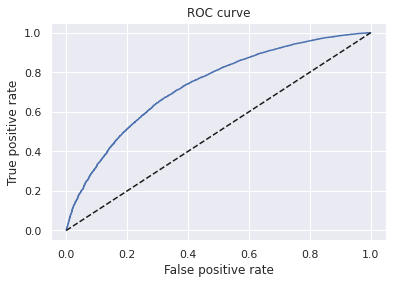

In [158]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [159]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.732790041807029

In [160]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.465580083614058

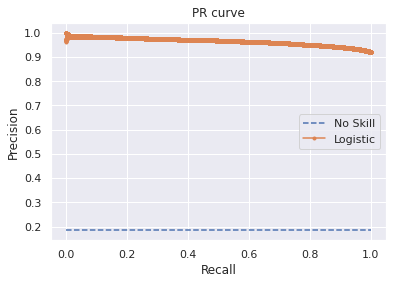

In [161]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [162]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.9642937627869879

# Scorecard Creation

In [163]:
df_scorecard = summary_table

In [164]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,Feature name,Coefficients,Original feature name
0,Intercept,-0.000745,Intercept
1,CODE_GENDER:M,-0.185916,CODE_GENDER
2,CODE_GENDER:F_XNA,0.183575,CODE_GENDER
3,NAME_EDUCATION_TYPE:Academic degree,1.023525,NAME_EDUCATION_TYPE
4,NAME_EDUCATION_TYPE:Higher education,0.060774,NAME_EDUCATION_TYPE
5,NAME_EDUCATION_TYPE:Incomplete higher,-0.155641,NAME_EDUCATION_TYPE
6,NAME_EDUCATION_TYPE:Lower secondary,-0.561725,NAME_EDUCATION_TYPE
7,NAME_EDUCATION_TYPE:Secondary / secondary special,-0.369274,NAME_EDUCATION_TYPE
8,NAME_FAMILY_STATUS:Single_Unknown,-0.043151,NAME_FAMILY_STATUS
9,NAME_FAMILY_STATUS:Civil marriage,-0.073782,NAME_FAMILY_STATUS


In [165]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [166]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,Intercept,-0.000745,Intercept,569.507887,570.0
1,CODE_GENDER:M,-0.185916,CODE_GENDER,-9.787453,-10.0
2,CODE_GENDER:F_XNA,0.183575,CODE_GENDER,9.664248,10.0
3,NAME_EDUCATION_TYPE:Academic degree,1.023525,NAME_EDUCATION_TYPE,53.883070,54.0
4,NAME_EDUCATION_TYPE:Higher education,0.060774,NAME_EDUCATION_TYPE,3.199428,3.0
5,NAME_EDUCATION_TYPE:Incomplete higher,-0.155641,NAME_EDUCATION_TYPE,-8.193641,-8.0
6,NAME_EDUCATION_TYPE:Lower secondary,-0.561725,NAME_EDUCATION_TYPE,-29.571763,-30.0
7,NAME_EDUCATION_TYPE:Secondary / secondary special,-0.369274,NAME_EDUCATION_TYPE,-19.440297,-19.0
8,NAME_FAMILY_STATUS:Single_Unknown,-0.043151,NAME_FAMILY_STATUS,-2.271653,-2.0
9,NAME_FAMILY_STATUS:Civil marriage,-0.073782,NAME_FAMILY_STATUS,-3.884221,-4.0


In [167]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
849.0


In [168]:
pd.options.display.max_rows = 75
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard.sort_values(by = ['Score - Preliminary','Difference'])

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
65,EXT_SOURCE_3:<0.0901,-1.238658,EXT_SOURCE_3,-65.208628,-65.0,0.208628
55,EXT_SOURCE_2:<0.0855,-0.976513,EXT_SOURCE_2,-51.408137,-51.0,0.408137
15,NAME_INCOME_TYPE:student_unemployed,-0.924586,NAME_INCOME_TYPE,-48.674433,-49.0,-0.325567
66,EXT_SOURCE_3:0.0901-0.18,-0.903658,EXT_SOURCE_3,-47.572720,-48.0,-0.427280
56,EXT_SOURCE_2:0.0855-0.171,-0.638114,EXT_SOURCE_2,-33.593247,-34.0,-0.406753
67,EXT_SOURCE_3:0.18-0.269,-0.605718,EXT_SOURCE_3,-31.887773,-32.0,-0.112227
6,NAME_EDUCATION_TYPE:Lower secondary,-0.561725,NAME_EDUCATION_TYPE,-29.571763,-30.0,-0.428237
57,EXT_SOURCE_2:0.171-0.256,-0.446605,EXT_SOURCE_2,-23.511336,-24.0,-0.488664
7,NAME_EDUCATION_TYPE:Secondary / secondary special,-0.369274,NAME_EDUCATION_TYPE,-19.440297,-19.0,0.440297
68,EXT_SOURCE_3:0.269-0.359,-0.258810,EXT_SOURCE_3,-13.624929,-14.0,-0.375071


In [169]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[65, 'Score - Final'] = -65 # plus one on EXT_SOURCE_3:<0.0901
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,-0.000745,Intercept,569.507887,570.0,0.492113,570.0
1,CODE_GENDER:M,-0.185916,CODE_GENDER,-9.787453,-10.0,-0.212547,-10.0
2,CODE_GENDER:F_XNA,0.183575,CODE_GENDER,9.664248,10.0,0.335752,10.0
3,NAME_EDUCATION_TYPE:Academic degree,1.023525,NAME_EDUCATION_TYPE,53.883070,54.0,0.116930,54.0
4,NAME_EDUCATION_TYPE:Higher education,0.060774,NAME_EDUCATION_TYPE,3.199428,3.0,-0.199428,3.0
5,NAME_EDUCATION_TYPE:Incomplete higher,-0.155641,NAME_EDUCATION_TYPE,-8.193641,-8.0,0.193641,-8.0
6,NAME_EDUCATION_TYPE:Lower secondary,-0.561725,NAME_EDUCATION_TYPE,-29.571763,-30.0,-0.428237,-30.0
7,NAME_EDUCATION_TYPE:Secondary / secondary special,-0.369274,NAME_EDUCATION_TYPE,-19.440297,-19.0,0.440297,-19.0
8,NAME_FAMILY_STATUS:Single_Unknown,-0.043151,NAME_FAMILY_STATUS,-2.271653,-2.0,0.271653,-2.0
9,NAME_FAMILY_STATUS:Civil marriage,-0.073782,NAME_FAMILY_STATUS,-3.884221,-4.0,-0.115779,-4.0


In [170]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
849.0


In [171]:
df_scorecard[['Original feature name','Score - Final']]

,Original feature name,Score - Final
0,Intercept,570.0
1,CODE_GENDER,-10.0
2,CODE_GENDER,10.0
3,NAME_EDUCATION_TYPE,54.0
4,NAME_EDUCATION_TYPE,3.0
5,NAME_EDUCATION_TYPE,-8.0
6,NAME_EDUCATION_TYPE,-30.0
7,NAME_EDUCATION_TYPE,-19.0
8,NAME_FAMILY_STATUS,-2.0
9,NAME_FAMILY_STATUS,-4.0


## Calculating credit scores for all observations in the test data set

In [172]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,CODE_GENDER:M,CODE_GENDER:F_XNA,NAME_EDUCATION_TYPE:Academic degree,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_FAMILY_STATUS:Single_Unknown,NAME_FAMILY_STATUS:Civil marriage,NAME_FAMILY_STATUS:Married,NAME_FAMILY_STATUS:Separated,NAME_FAMILY_STATUS:Widow,NAME_INCOME_TYPE:Business_comm,NAME_INCOME_TYPE:Pensioner_maternity,NAME_INCOME_TYPE:student_unemployed,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,REG_CITY_NOT_LIVE_CITY:0,REG_CITY_NOT_LIVE_CITY:1,FLAG_DOCUMENT_3:0,FLAG_DOCUMENT_3:1,REGION_RATING_CLIENT_W_CITY:0,REGION_RATING_CLIENT_W_CITY:1,REGION_RATING_CLIENT_W_CITY:2,REGION_POPULATION_RELATIVE:<0.0147,REGION_POPULATION_RELATIVE:0.0147-0.0292,REGION_POPULATION_RELATIVE:0.0292-0.0436,REGION_POPULATION_RELATIVE:0.0436-0.0581,REGION_POPULATION_RELATIVE:>0.0581,YEAR_LAST_PHONE_CHANGE:<2,YEAR_LAST_PHONE_CHANGE:2-4,YEAR_LAST_PHONE_CHANGE:4-6,YEAR_LAST_PHONE_CHANGE:6-8,YEAR_LAST_PHONE_CHANGE:8-10,YEAR_LAST_PHONE_CHANGE:>10,AMT_CREDIT:<846000,AMT_CREDIT:846000-1647000,AMT_CREDIT:1647000-2448000,AMT_CREDIT:2448000-3249000,AMT_CREDIT:>3249000,YEAR_ID_PUBLISH:<4,YEAR_ID_PUBLISH:4-8,YEAR_ID_PUBLISH:8-12,YEAR_ID_PUBLISH:12-16,YEAR_ID_PUBLISH:>16,YEAR_REGISTRATION:<17,YEAR_REGISTRATION:17-34,YEAR_REGISTRATION:34-51,YEAR_REGISTRATION:>51,YEAR_BIRTH:<30,YEAR_BIRTH:30-40,YEAR_BIRTH:40-50,YEAR_BIRTH:50-60,YEAR_BIRTH:>60,EXT_SOURCE_2:<0.0855,EXT_SOURCE_2:0.0855-0.171,EXT_SOURCE_2:0.171-0.256,EXT_SOURCE_2:0.256-0.342,EXT_SOURCE_2:0.342-0.427,EXT_SOURCE_2:0.427-0.513,EXT_SOURCE_2:0.513-0.598,EXT_SOURCE_2:0.598-0.684,EXT_SOURCE_2:0.684-0.769,EXT_SOURCE_2:>0.769,EXT_SOURCE_3:<0.0901,EXT_SOURCE_3:0.0901-0.18,EXT_SOURCE_3:0.18-0.269,EXT_SOURCE_3:0.269-0.359,EXT_SOURCE_3:0.359-0.448,EXT_SOURCE_3:0.448-0.538,EXT_SOURCE_3:0.538-0.627,EXT_SOURCE_3:0.627-0.717,EXT_SOURCE_3:0.717-0.806,EXT_SOURCE_3:>0.806
128081,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
68695,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
280602,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
93006,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
125876,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [173]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final'].to_frame().to_numpy()
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(61503, 75)
(75, 1)


In [174]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
128081,610.0
68695,557.0
280602,595.0
93006,552.0
125876,558.0


## Setting loan approval cut-offs

In [175]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.300276


Best Threshold: 0.299570

This means that based on the Youden's J statistic, the ideal probability threshold is 0.299570 which minimizes the FPR and maximimizes the TPR - all samples with a predicted probability higher than this should be classified as in Default and vice versa.

We can confirm this by looking at our original confusion matrix with the updated threshold

In [176]:
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
print(classification_report(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted']))

              precision    recall  f1-score   support

           0       0.15      0.67      0.25      4965
           1       0.96      0.68      0.80     56538

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503



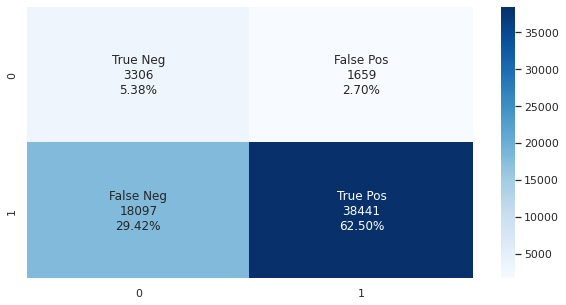

In [177]:
z= confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                z.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     z.flatten()/np.sum(z)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10, 5))
sns.heatmap(z, annot=labels, fmt='', cmap='Blues')

In [178]:
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
print(classification_report(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted']))

              precision    recall  f1-score   support

           0       0.25      0.30      0.28      4965
           1       0.94      0.92      0.93     56538

    accuracy                           0.87     61503
   macro avg       0.59      0.61      0.60     61503
weighted avg       0.88      0.87      0.88     61503



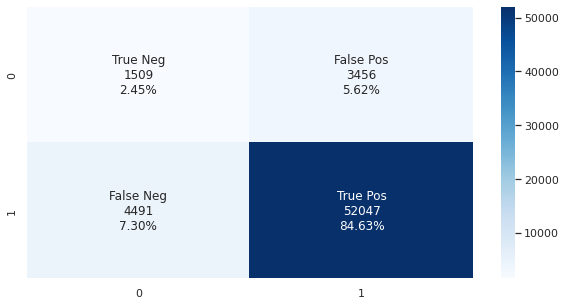

In [179]:
z= confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                z.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     z.flatten()/np.sum(z)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10, 5))
sns.heatmap(z, annot=labels, fmt='', cmap='Blues')

In [180]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs.head()

,thresholds,Score
0,0.037350,398.0
1,0.038450,400.0
2,0.040310,403.0
3,0.040995,404.0
4,0.043852,407.0


In [181]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [182]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.037350,398.0,61503,0,1.000000,0.000000
1,0.038450,400.0,61502,1,0.999984,0.000016
2,0.040310,403.0,61501,2,0.999967,0.000033
3,0.040995,404.0,61500,3,0.999951,0.000049
4,0.043852,407.0,61499,4,0.999935,0.000065


In [183]:
best_thresh

0.30027572054795837

In [184]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.299570, 0.29958)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate


In [185]:
# compare the above rates with the case of the default 0.5 threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.5, 0.5001)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
20179,0.500002,570.0,40100,21403,0.652001,0.347999
20180,0.500005,570.0,40099,21404,0.651984,0.348016
20181,0.500006,570.0,40098,21405,0.651968,0.348032
20182,0.500030,570.0,40097,21406,0.651952,0.348048
20183,0.500048,570.0,40096,21407,0.651936,0.348064
20184,0.500050,570.0,40095,21408,0.651919,0.348081
20185,0.500054,570.0,40094,21409,0.651903,0.348097
20186,0.500057,570.0,40093,21410,0.651887,0.348113
20187,0.500075,570.0,40092,21411,0.651871,0.348129
20188,0.500082,570.0,40091,21412,0.651854,0.348146


0.5 threshold would result in a very high rejection rate with a corresponding loss of business.

Accordingly, we will stick with our ideal threshold and the corresponding Credit Score of 524, and will monitor the model's performance in production

In [186]:
df_scorecard['specific feature'] = df_scorecard['Feature name'].apply(lambda x: x.split(":")[1] if x != 'Intercept' else 'Intercept')

In [187]:
df_scorecard[['Original feature name', 'specific feature', 'Score - Final']]

,Original feature name,specific feature,Score - Final
0,Intercept,Intercept,570.0
1,CODE_GENDER,M,-10.0
2,CODE_GENDER,F_XNA,10.0
3,NAME_EDUCATION_TYPE,Academic degree,54.0
4,NAME_EDUCATION_TYPE,Higher education,3.0
5,NAME_EDUCATION_TYPE,Incomplete higher,-8.0
6,NAME_EDUCATION_TYPE,Lower secondary,-30.0
7,NAME_EDUCATION_TYPE,Secondary / secondary special,-19.0
8,NAME_FAMILY_STATUS,Single_Unknown,-2.0
9,NAME_FAMILY_STATUS,Civil marriage,-4.0


# Predict Dataset Test

In [188]:
df_test = pd.read_csv('application_test.csv')

In [189]:
df_test = df_test[selected_cols]

In [190]:
df_test[selected_num_cols] = numimputer.transform(df_test[selected_num_cols])

In [191]:
df_test = dummy_creation(df_test, selected_cat_cols)

In [192]:
df_test = df_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [193]:
df_test.head()

,FLAG_OWN_CAR,CODE_GENDER,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_LIVE_CITY,DAYS_EMPLOYED,FLAG_DOCUMENT_3,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,AMT_CREDIT,FLAG_DOCUMENT_6,CNT_CHILDREN,FLAG_OWN_CAR:N,FLAG_OWN_CAR:Y,CODE_GENDER:F,CODE_GENDER:M,CODE_GENDER:XNA,NAME_EDUCATION_TYPE:Academic degree,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_FAMILY_STATUS:Civil marriage,NAME_FAMILY_STATUS:Married,NAME_FAMILY_STATUS:Separated,NAME_FAMILY_STATUS:Single / not married,NAME_FAMILY_STATUS:Unknown,NAME_FAMILY_STATUS:Widow,NAME_INCOME_TYPE:Businessman,NAME_INCOME_TYPE:Commercial associate,NAME_INCOME_TYPE:Maternity leave,NAME_INCOME_TYPE:Pensioner,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Student,NAME_INCOME_TYPE:Unemployed,NAME_INCOME_TYPE:Working
0,N,F,Higher education,Married,Working,0.789654,0.159520,-19241.0,2.0,-1740.0,-812.0,0.0,-2329.0,1.0,-5170.0,0.018850,0.0,568800.0,0.0,0.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,N,M,Secondary / secondary special,Married,Working,0.291656,0.432962,-18064.0,2.0,0.0,-1623.0,0.0,-4469.0,1.0,-9118.0,0.035792,0.0,222768.0,0.0,0.0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,Y,M,Higher education,Married,Working,0.699787,0.610991,-20038.0,2.0,-856.0,-3503.0,0.0,-4458.0,0.0,-2175.0,0.019101,0.0,663264.0,0.0,0.0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,N,F,Secondary / secondary special,Married,Working,0.509677,0.612704,-13976.0,2.0,-1805.0,-4208.0,0.0,-1866.0,1.0,-2000.0,0.026392,0.0,1575000.0,0.0,2.0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Y,M,Secondary / secondary special,Married,Working,0.425687,0.535276,-13040.0,2.0,-821.0,-4262.0,0.0,-2191.0,1.0,-4000.0,0.010032,1.0,625500.0,0.0,1.0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [194]:
df_test.shape

(48744, 44)

In [195]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.transform(df_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,CODE_GENDER:M,CODE_GENDER:F_XNA,NAME_EDUCATION_TYPE:Academic degree,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_FAMILY_STATUS:Single_Unknown,NAME_FAMILY_STATUS:Civil marriage,NAME_FAMILY_STATUS:Married,NAME_FAMILY_STATUS:Separated,NAME_FAMILY_STATUS:Widow,NAME_INCOME_TYPE:Business_comm,NAME_INCOME_TYPE:Pensioner_maternity,NAME_INCOME_TYPE:student_unemployed,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,REG_CITY_NOT_LIVE_CITY:0,REG_CITY_NOT_LIVE_CITY:1,FLAG_DOCUMENT_3:0,FLAG_DOCUMENT_3:1,REGION_RATING_CLIENT_W_CITY:0,REGION_RATING_CLIENT_W_CITY:1,REGION_RATING_CLIENT_W_CITY:2,REGION_POPULATION_RELATIVE:<0.0147,REGION_POPULATION_RELATIVE:0.0147-0.0292,REGION_POPULATION_RELATIVE:0.0292-0.0436,REGION_POPULATION_RELATIVE:0.0436-0.0581,REGION_POPULATION_RELATIVE:>0.0581,YEAR_LAST_PHONE_CHANGE:<2,YEAR_LAST_PHONE_CHANGE:2-4,YEAR_LAST_PHONE_CHANGE:4-6,YEAR_LAST_PHONE_CHANGE:6-8,YEAR_LAST_PHONE_CHANGE:8-10,YEAR_LAST_PHONE_CHANGE:>10,AMT_CREDIT:<846000,AMT_CREDIT:846000-1647000,AMT_CREDIT:1647000-2448000,AMT_CREDIT:2448000-3249000,AMT_CREDIT:>3249000,YEAR_ID_PUBLISH:<4,YEAR_ID_PUBLISH:4-8,YEAR_ID_PUBLISH:8-12,YEAR_ID_PUBLISH:12-16,YEAR_ID_PUBLISH:>16,YEAR_REGISTRATION:<17,YEAR_REGISTRATION:17-34,YEAR_REGISTRATION:34-51,YEAR_REGISTRATION:>51,YEAR_BIRTH:<30,YEAR_BIRTH:30-40,YEAR_BIRTH:40-50,YEAR_BIRTH:50-60,YEAR_BIRTH:>60,EXT_SOURCE_2:<0.0855,EXT_SOURCE_2:0.0855-0.171,EXT_SOURCE_2:0.171-0.256,EXT_SOURCE_2:0.256-0.342,EXT_SOURCE_2:0.342-0.427,EXT_SOURCE_2:0.427-0.513,EXT_SOURCE_2:0.513-0.598,EXT_SOURCE_2:0.598-0.684,EXT_SOURCE_2:0.684-0.769,EXT_SOURCE_2:>0.769,EXT_SOURCE_3:<0.0901,EXT_SOURCE_3:0.0901-0.18,EXT_SOURCE_3:0.18-0.269,EXT_SOURCE_3:0.269-0.359,EXT_SOURCE_3:0.359-0.448,EXT_SOURCE_3:0.448-0.538,EXT_SOURCE_3:0.538-0.627,EXT_SOURCE_3:0.627-0.717,EXT_SOURCE_3:0.717-0.806,EXT_SOURCE_3:>0.806
0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [196]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final'].to_frame().to_numpy()
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(48744, 75)
(75, 1)


In [197]:
# matrix dot multiplication of test set with scorecard scores
y_test_scores = X_test_woe_transformed.dot(scorecard_scores)
y_test_scores.head()

,0
0,601.0
1,525.0
2,652.0
3,594.0
4,537.0


In [198]:
# create a new DF comprising of the thresholds from the ROC output
df_test_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_test_cutoffs['Score'] = ((np.log(df_test_cutoffs['thresholds'] / (1 - df_test_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_test_cutoffs.head()

,thresholds,Score
0,0.037350,398.0
1,0.038450,400.0
2,0.040310,403.0
3,0.040995,404.0
4,0.043852,407.0


In [199]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [200]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_test_cutoffs['N Approved'] = df_test_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_test_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_test_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_test_cutoffs['Approval Rate'] = df_test_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_test_cutoffs['Rejection Rate'] = 1 - df_test_cutoffs['Approval Rate']
df_test_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.037350,398.0,61503,0,1.000000,0.000000
1,0.038450,400.0,61502,1,0.999984,0.000016
2,0.040310,403.0,61501,2,0.999967,0.000033
3,0.040995,404.0,61500,3,0.999951,0.000049
4,0.043852,407.0,61499,4,0.999935,0.000065


In [201]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.299570, 0.299573)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate


In [202]:
# compare the above rates with the case of the default 0.5 threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.5, 0.5001)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
20179,0.500002,570.0,40100,21403,0.652001,0.347999
20180,0.500005,570.0,40099,21404,0.651984,0.348016
20181,0.500006,570.0,40098,21405,0.651968,0.348032
20182,0.500030,570.0,40097,21406,0.651952,0.348048
20183,0.500048,570.0,40096,21407,0.651936,0.348064
20184,0.500050,570.0,40095,21408,0.651919,0.348081
20185,0.500054,570.0,40094,21409,0.651903,0.348097
20186,0.500057,570.0,40093,21410,0.651887,0.348113
20187,0.500075,570.0,40092,21411,0.651871,0.348129
20188,0.500082,570.0,40091,21412,0.651854,0.348146
